In [1]:
import sys
import os
from os.path import isfile, join
import re
sys.path.append("/home/jemonet/Documents/These/Code/Graphes")
sys.path.append("/user/jemonet/home/Documents/These/stimuli")
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from figure_lib.src.data_transform.GraphDF import GraphDF
# from figure_lib.src.make_figure.figure import Figure
import seaborn as sns
import matplotlib as mpl

import figure_lib.src.data_transform.GraphDF as gdf
import figure_lib.src.data_transform.listMatrix2D as lm2D
import figure_lib.src.make_figure.figure as fg
import figure_lib.src.make_figure.graphFigure as gfg
import figure_lib.src.make_figure.heatmapFigure as hmf
import stim_help_functions as hf


#%matplotlib qt
%matplotlib inline

In [2]:
# Méthode pour calculer la dérivée d'un gdf.
def compute_derivate(df):
    df_dXdt = pd.DataFrame(np.NaN, index=df.data.index, columns=df.data.columns)
    for i_cell in range(len(df.data.columns)):
        for i_time in range(len(df.data.index)):
            if i_time == 0:
                t_moins1 = df.data.iloc[[i_time],[i_cell]]
                t_plus1 = df.data.iloc[[i_time+1],[i_cell]]
                df_dXdt.iloc[[i_time],[i_cell]] = (t_plus1.iloc[0,0] - t_moins1.iloc[0,0]) / (t_plus1.index[0] - t_moins1.index[0])

            elif i_time == len(df.data.index)-1:
                t_moins1 = df.data.iloc[[i_time-1],[i_cell]]
                t_plus1 = df.data.iloc[[i_time],[i_cell]]
                df_dXdt.iloc[[i_time],[i_cell]] = (t_plus1.iloc[0,0] - t_moins1.iloc[0,0]) / (t_plus1.index[0] - t_moins1.index[0])

            else:
                t_moins1 = df.data.iloc[[i_time-1],[i_cell]]
                t_plus1 = df.data.iloc[[i_time+1],[i_cell]]
                df_dXdt.iloc[[i_time],[i_cell]] = (t_plus1.iloc[0,0] - t_moins1.iloc[0,0]) / (t_plus1.index[0] - t_moins1.index[0])

    return df_dXdt

# Méthode pour calculer la dérivée d'un dataframe.
def compute_derivate_df(df):
    df_dXdt = pd.DataFrame(np.NaN, index=df.index, columns=df.columns)
    for i_cell in range(len(df.columns)):
        for i_time in range(len(df.index)):
            if i_time == 0:
                t_moins1 = df.iloc[[i_time],[i_cell]]
                t_plus1 = df.iloc[[i_time+1],[i_cell]]
                if t_plus1.index[0] - t_moins1.index[0] != 0:
                    df_dXdt.iloc[[i_time],[i_cell]] = (t_plus1.iloc[0,0] - t_moins1.iloc[0,0]) / (t_plus1.index[0] - t_moins1.index[0])
                else:
                    df_dXdt.iloc[[i_time],[i_cell]] = 0

            elif i_time == len(df.index)-1:
                t_moins1 = df.iloc[[i_time-1],[i_cell]]
                t_plus1 = df.iloc[[i_time],[i_cell]]
                if t_plus1.index[0] - t_moins1.index[0] != 0:
                    df_dXdt.iloc[[i_time],[i_cell]] = (t_plus1.iloc[0,0] - t_moins1.iloc[0,0]) / (t_plus1.index[0] - t_moins1.index[0])
                else:
                    df_dXdt.iloc[[i_time],[i_cell]] = 0
            else:
                t_moins1 = df.iloc[[i_time-1],[i_cell]]
                t_plus1 = df.iloc[[i_time+1],[i_cell]]
                if t_plus1.index[0] - t_moins1.index[0] != 0:
                    df_dXdt.iloc[[i_time],[i_cell]] = (t_plus1.iloc[0,0] - t_moins1.iloc[0,0]) / (t_plus1.index[0] - t_moins1.index[0])
                else:
                    df_dXdt.iloc[[i_time],[i_cell]] = 0

    return df_dXdt

# Modèles de code de création de graphes

## Plots de la classe graphFigure

### Graphe de base

In [25]:
%matplotlib inline
importlib.reload(gdf)
importlib.reload(fg)

path = "/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/31x31_newCorrGaussian/all_cells_31x31_0.0244_noGC_noAma_noSurr_extdrive0,002_VC300_LexLinhSpeedCorr_3f.csv"

df = gdf.GraphDF(path,0.0244,60,20,20)

df = df.crop(0.09)
df = df.isolate_dataframe_byoutputs("muVn")
num_exc = ",".join([str(i) for i in range(1249,1569,20)])
num_inh = ",".join([str(i) for i in range(1649,1969,20)])
exc = df.isolate_dataframe_columns_bynum(num_exc)
inh = df.isolate_dataframe_columns_bynum(num_inh)
# exc = df.isolate_dataframe_bytype("CorticalExcitatory")
# inh = df.isolate_dataframe_bytype("CorticalInhibitory")
exc.data = (abs((exc.data - exc.data.iloc[0].mean())) / abs(exc.data.iloc[0].mean()))
inh.data = (abs((inh.data - inh.data.iloc[0].mean())) / abs(inh.data.iloc[0].mean()))
# exc.data = ((exc.data - exc.data.iloc[0].mean()) / exc.data.iloc[0].mean())
# inh.data = ((inh.data - inh.data.iloc[0].mean()) / inh.data.iloc[0].mean())

col_exc_rename = {exc.data.columns[i]:f"CorticalColumn ({i}) vsdi" for i in range(exc.data.columns.shape[0])}
col_inh_rename = {inh.data.columns[i]:f"CorticalColumn ({i}) vsdi" for i in range(exc.data.columns.shape[0])}
exc.data = exc.data.rename(columns=col_exc_rename)
inh.data = inh.data.rename(columns=col_inh_rename)

vsdi = exc.copy()
vsdi.data=exc.data*0.8+inh.data*0.2

list_df = [vsdi]

params_fig = dict(wspace=0.2,hspace=0.4,height_ratios=[1,1],width_ratios=[1,1])

info_fig = {"title":"Simulation without GC, Ama, Surr and 31x31 grid cell","subtitles":["VSDI in function of time"],"xlabel":"Time (s)","ylabel":"VSDI",
"sharex":True,"sharey":False}

font_size = {"main_title":35, "subtitle":25, "xlabel":25, "ylabel":25, "g_xticklabel":25, "g_yticklabel":25, "legend":20}

params_plot = {"grid_color":"lightgray","grid_width":4,"ticklength":7,"tickwidth":3, 
               "plots_color":[[(0, 0, (i/(exc.data.shape[1]/2))) if i<exc.data.shape[1]/2 else (0, i/(exc.data.shape[1]/2) - 1, 1.0) for i in range(0,exc.data.shape[1],1)]]}

# params_plot = {"grid_color":"lightgray","grid_width":4,"ticklength":7,"tickwidth":3, 
#                "plots_color":[[(0, i/exc.data.shape[1], i/exc.data.shape[1]) for i in range(0,exc.data.shape[1]+1,1)]]

f = gfg.graphFigure(list_df,1,1,20,20,dict_info_fig=info_fig, dict_font_size=font_size,dict_params_plot=params_plot)
f.set_figure_legend((1,), fontsize=25)
f.ax.legend([f"{round(i*0.5166667,2)} deg" for i in range(vsdi.data.shape[0])],fontsize=25)
plt.tight_layout()
# plt.savefig("/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/31x31_newCorrGaussian/graphe_vsdi.png")

FileNotFoundError: [Errno 2] No such file or directory: '/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/31x31_newCorrGaussian/all_cells_31x31_0.0244_noGC_noAma_noSurr_extdrive0,002_VC300_LexLinhSpeedCorr_3f.csv'


-- Default values taken for figure parameters --


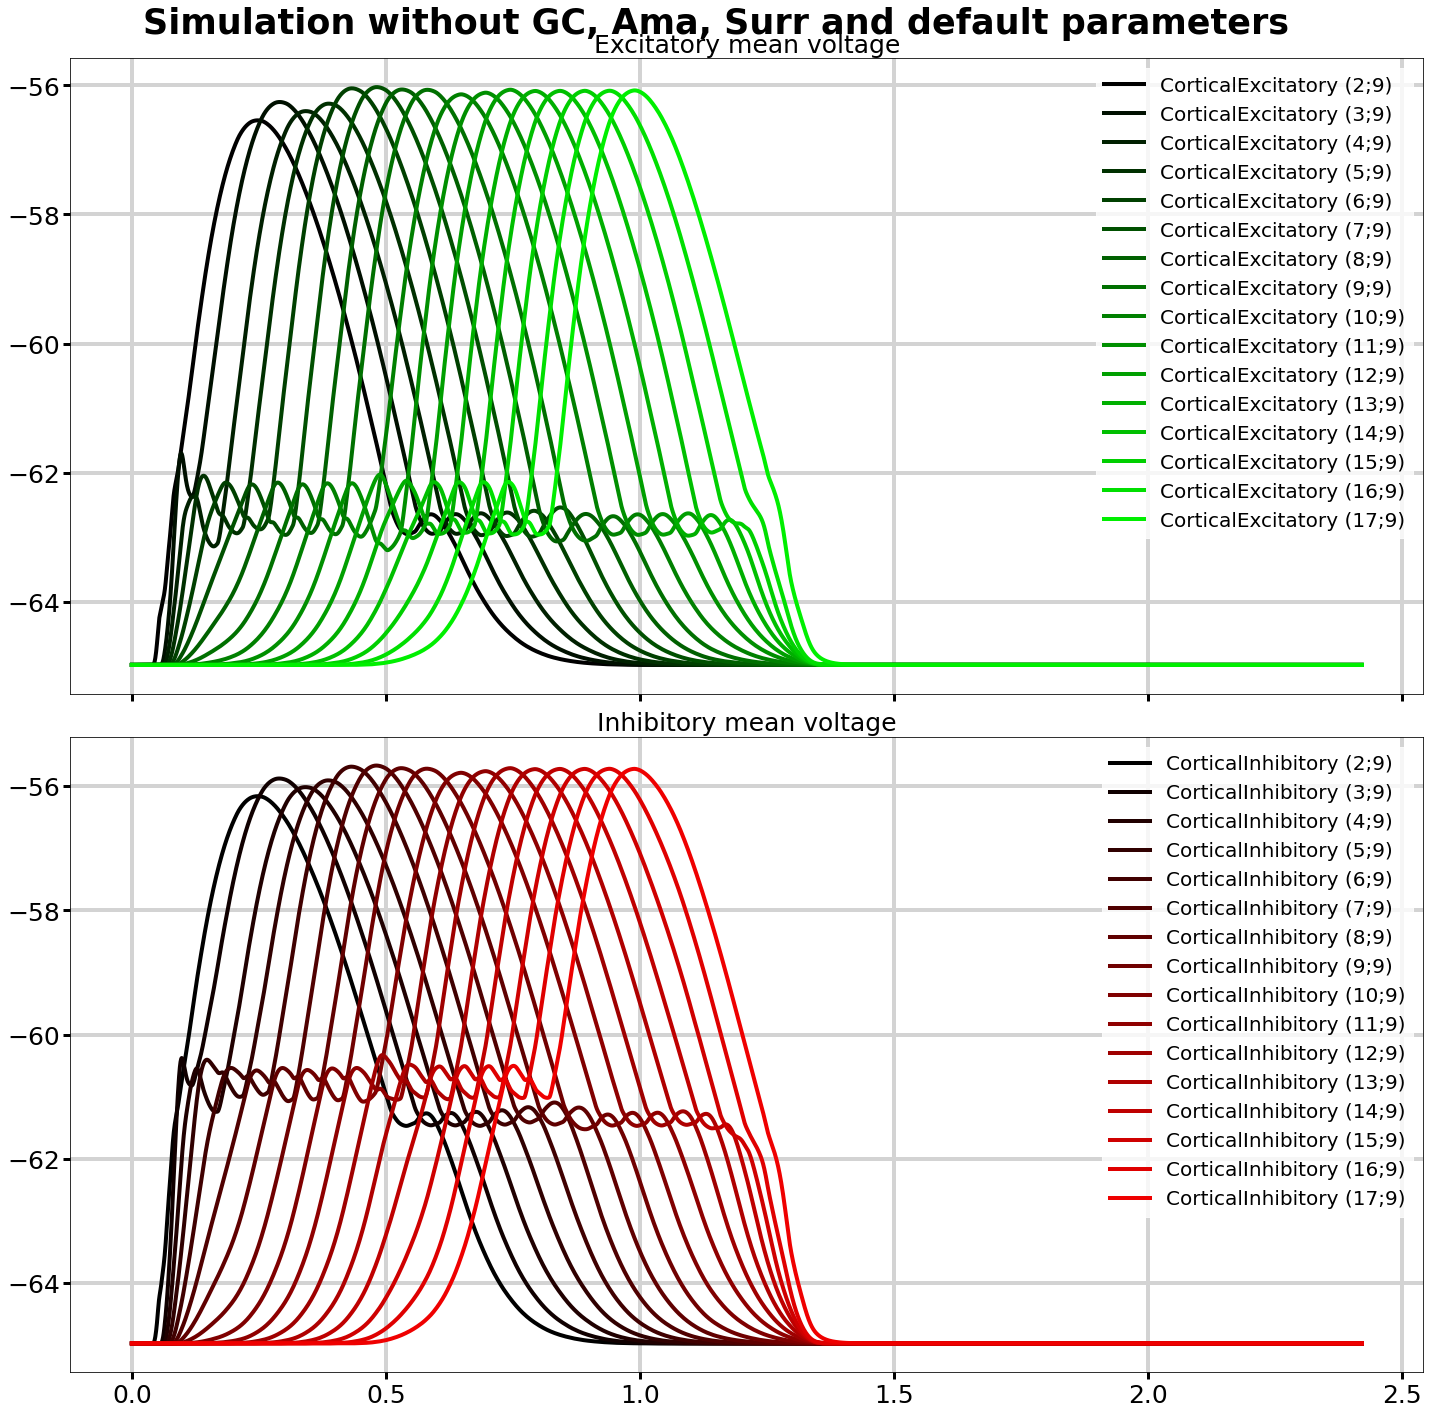

In [14]:
%matplotlib inline
importlib.reload(gdf)
importlib.reload(fg)

# path = "/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/all_cells_31x31_0.0244_noGC_noAma_noSurr_extdrive0,002_VC300_4f.csv"
path = "/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/31x31_newCorrGaussian/all_cells_31x31_0.0244_noGC_noAma_noSurr_extdrive0,002_VC300_3f.csv"
df = gdf.GraphDF(path,0.0233,60,20,20)

df = df.crop(0.09)
df = df.isolate_dataframe_byoutputs("muVn")
num_exc = ",".join([str(i) for i in range(1249,1569,20)])
num_inh = ",".join([str(i) for i in range(1649,1969,20)])
exc = df.isolate_dataframe_columns_bynum(num_exc)
inh = df.isolate_dataframe_columns_bynum(num_inh)

list_df = [exc, inh]

params_fig = dict(wspace=0.2,hspace=0.4,height_ratios=[1,1],width_ratios=[1,1])

info_fig = {"title":"Simulation without GC, Ama, Surr and default parameters","subtitles":["Excitatory mean voltage","Inhibitory mean voltage"],"xlabel":"Time (s)","ylabel":["Mean voltage (mV)","Mean voltage (mV)"],
"sharex":True,"sharey":False}

font_size = {"main_title":35, "subtitle":25, "xlabel":25, "ylabel":25, "g_xticklabel":25, "g_yticklabel":25, "legend":20}

params_plot = {"grid_color":"lightgray","grid_width":4,"ticklength":7,"tickwidth":3, 
               "plots_color":[[(0, i/exc.data.shape[1], 0) for i in range(0,exc.data.shape[1],1)],[(i/exc.data.shape[1], 0, 0) for i in range(0,exc.data.shape[1],1)]]}


f = gfg.graphFigure(list_df,2,1,20,20,dict_info_fig=info_fig, dict_font_size=font_size,dict_params_plot=params_plot)
f.set_figure_legend((1,2), fontsize=20)
plt.tight_layout()
# plt.savefig("/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/31x31_newCorrGaussian/graphe_muV.png")

### Graphe centré sur le pic

In [ ]:
%matplotlib inline
importlib.reload(gdf)
importlib.reload(fg)

# path = "/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/all_cells_withGang_31x31_0.0233_noGC_noAma_noSurr_extdrive0,002_VC300_4f.csv"
# n_frame = int(re.search(r"[0-9]{1,3}f",path)[0][:-1])

path_dir = "/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/test"

re_files = re.compile(r"[0-9]{1,3}x[0-9]{1,3}_dt[01],[0-9]{1,7}.*_[0-9]{1,3}f.csv")
re_size = re.compile(r"[0-9]{1,3}x[0-9]{1,3}")
re_dt =re.compile(r"dt[01],[0-9]{1,7}")
re_n_frame = re.compile(r"[0-9]{1,3}f")

files = [f for f in os.listdir(path_dir) if isfile(join(path_dir,f)) and re_files.findall(f) != []]
files.sort(key = lambda x : float(re_dt.findall(x)[0][2:].replace(",",".")))

for file in files:
    path_load = f"{path_dir}/{file}"
    size = re_size.findall(file)[0][:]
    dt = float(re_dt.findall(file)[0][2:].replace(",","."))
    n_frame = int(re_n_frame.findall(file)[0][:-1])
    speed_stim = round(1.8/(43*dt)*10/3)
    path_out = f"{path_dir}/VSDI_dt{dt}_speedStim{speed_stim}.png"
             
    print(size, dt, n_frame, speed_stim)
    print(f"Response of cortical columns to a white bar moving at {speed_stim}°/s\n")
    print(path_out)

    df = gdf.GraphDF(path_load,dt,60,20,20)
    df = df.crop(df.dt*n_frame)
    df.data.index *= 1000
    df = df.isolate_dataframe_byoutputs("muVn")
    num_exc = ",".join([str(i) for i in range(1249,1569,20)])
    num_inh = ",".join([str(i) for i in range(1649,1969,20)])
    exc = df.isolate_dataframe_columns_bynum(num_exc)
    inh = df.isolate_dataframe_columns_bynum(num_inh)
    # exc = df.isolate_dataframe_bytype("CorticalExcitatory")
    # inh = df.isolate_dataframe_bytype("CorticalInhibitory")
    exc.data = (abs((exc.data - exc.data.iloc[0].mean())) / abs(exc.data.iloc[0].mean()))
    inh.data = (abs((inh.data - inh.data.iloc[0].mean())) / abs(inh.data.iloc[0].mean()))
    # exc.data = ((exc.data - exc.data.iloc[0].mean()) / exc.data.iloc[0].mean())
    # inh.data = ((inh.data - inh.data.iloc[0].mean()) / inh.data.iloc[0].mean())

    col_exc_rename = {exc.data.columns[i]:f"CorticalColumn ({i}) vsdi" for i in range(exc.data.columns.shape[0])}
    col_inh_rename = {inh.data.columns[i]:f"CorticalColumn ({i}) vsdi" for i in range(exc.data.columns.shape[0])}
    exc.data = exc.data.rename(columns=col_exc_rename)
    inh.data = inh.data.rename(columns=col_inh_rename)

    vsdi = exc.copy()
    vsdi.data=exc.data*0.8+inh.data*0.2
    vsdi_c=vsdi.tmax_centering_df()

    list_df = [vsdi_c]

    params_fig = dict(wspace=0.2,hspace=0.4,height_ratios=[1,1],width_ratios=[1,1])

    info_fig = {"title":f"Response of cortical columns to a white bar moving at {speed_stim}°/s\n","subtitles":[""],"xlabel":"Time (ms)","ylabel":"VSDI",
    "sharex":True,"sharey":False}

    font_size = {"main_title":50, "subtitle":40, "xlabel":40, "ylabel":40, "g_xticklabel":40, "g_yticklabel":40, "legend":30}

    params_plot = {"grid_color":"lightgray","grid_width":4,"ticklength":7,"tickwidth":3, "labelpad":20, 
                   "plots_color":[[(0, 0, (i/(exc.data.shape[1]/2))) if i<exc.data.shape[1]/2 else (0, i/(exc.data.shape[1]/2) - 1, 1.0) for i in range(0,exc.data.shape[1],1)]]}

    # params_plot = {"grid_color":"lightgray","grid_width":4,"ticklength":7,"tickwidth":3, 
    #                "plots_color":[[(0, i/exc.data.shape[1], i/exc.data.shape[1]) for i in range(0,exc.data.shape[1]+1,1)]]}

    f = gfg.graphFigure(list_df,1,1,20,20,dict_info_fig=info_fig, dict_font_size=font_size,dict_params_plot=params_plot)

    # f.set_figure_legend((1,), fontsize=25)
    f.ax.legend([f"{round(i*0.5166667,2)} deg" for i in range(len(vsdi_c))],fontsize=25)
    plt.tight_layout()
    plt.savefig(path_out, bbox_inches='tight')


-- Default values taken for figure parameters --


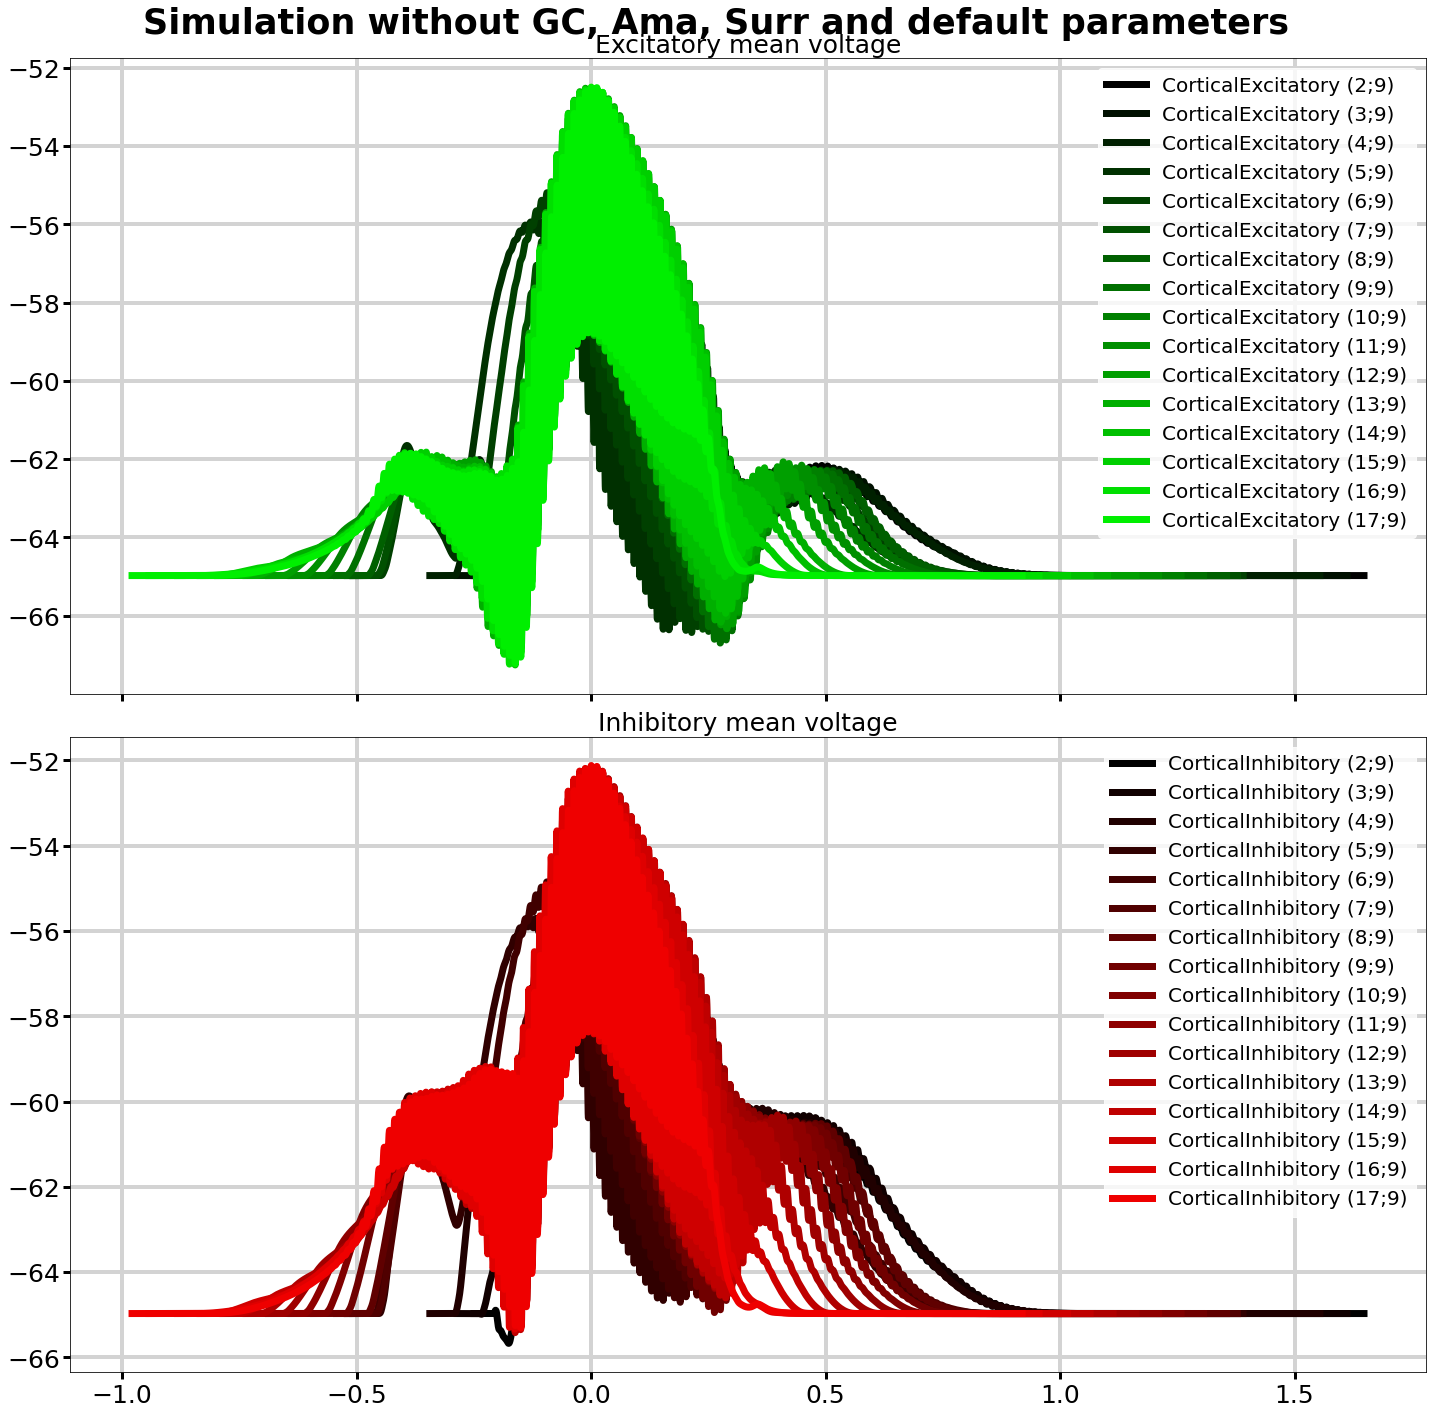

In [ ]:
%matplotlib inline
importlib.reload(gdf)
importlib.reload(fg)

# path = "/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/all_cells_31x31_0.0244_noGC_noAma_noSurr_extdrive0,002_VC300_4f.csv"
path = "/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/31x31_newCorrGaussian/all_cells_31x31_0.0244_noGC_noAma_noSurr_extdrive0,002_VC300_LexLinhSpeedCorr_3f.csv"
df = gdf.GraphDF(path,0.0233,60,20,20)

df = df.crop(0.09)
df = df.isolate_dataframe_byoutputs("muVn")
num_exc = ",".join([str(i) for i in range(1249,1569,20)])
num_inh = ",".join([str(i) for i in range(1649,1969,20)])
exc = df.isolate_dataframe_columns_bynum(num_exc)
inh = df.isolate_dataframe_columns_bynum(num_inh)
inh_c=inh.tmax_centering_df()
exc_c=exc.tmax_centering_df()

list_df = [exc_c, inh_c]

params_fig = dict(wspace=0.2,hspace=0.4,height_ratios=[1,1],width_ratios=[1,1])

info_fig = {"title":"Simulation without GC, Ama, Surr and default parameters","subtitles":["Excitatory mean voltage","Inhibitory mean voltage"],"xlabel":"Time (s)","ylabel":["Mean voltage (mV)","Mean voltage (mV)"],
"sharex":True,"sharey":False}

font_size = {"main_title":35, "subtitle":25, "xlabel":25, "ylabel":25, "g_xticklabel":25, "g_yticklabel":25, "legend":20}

params_plot = {"grid_color":"lightgray","grid_width":4,"ticklength":7,"tickwidth":3, 
               "plots_color":[[(0, i/exc.data.shape[1], 0) for i in range(0,exc.data.shape[1],1)],[(i/exc.data.shape[1], 0, 0) for i in range(0,exc.data.shape[1],1)]]}


f = gfg.graphFigure(list_df,2,1,20,20,dict_info_fig=info_fig, dict_font_size=font_size,dict_params_plot=params_plot)
f.set_figure_legend((1,2), fontsize=20)
plt.tight_layout()
# plt.savefig("/user/jemonet/home/Documents/These/Code/Graphes/figure_lib/tests/results_tests/graphFigure/graphe_centré_pic.png")


-- Default values taken for figure parameters --


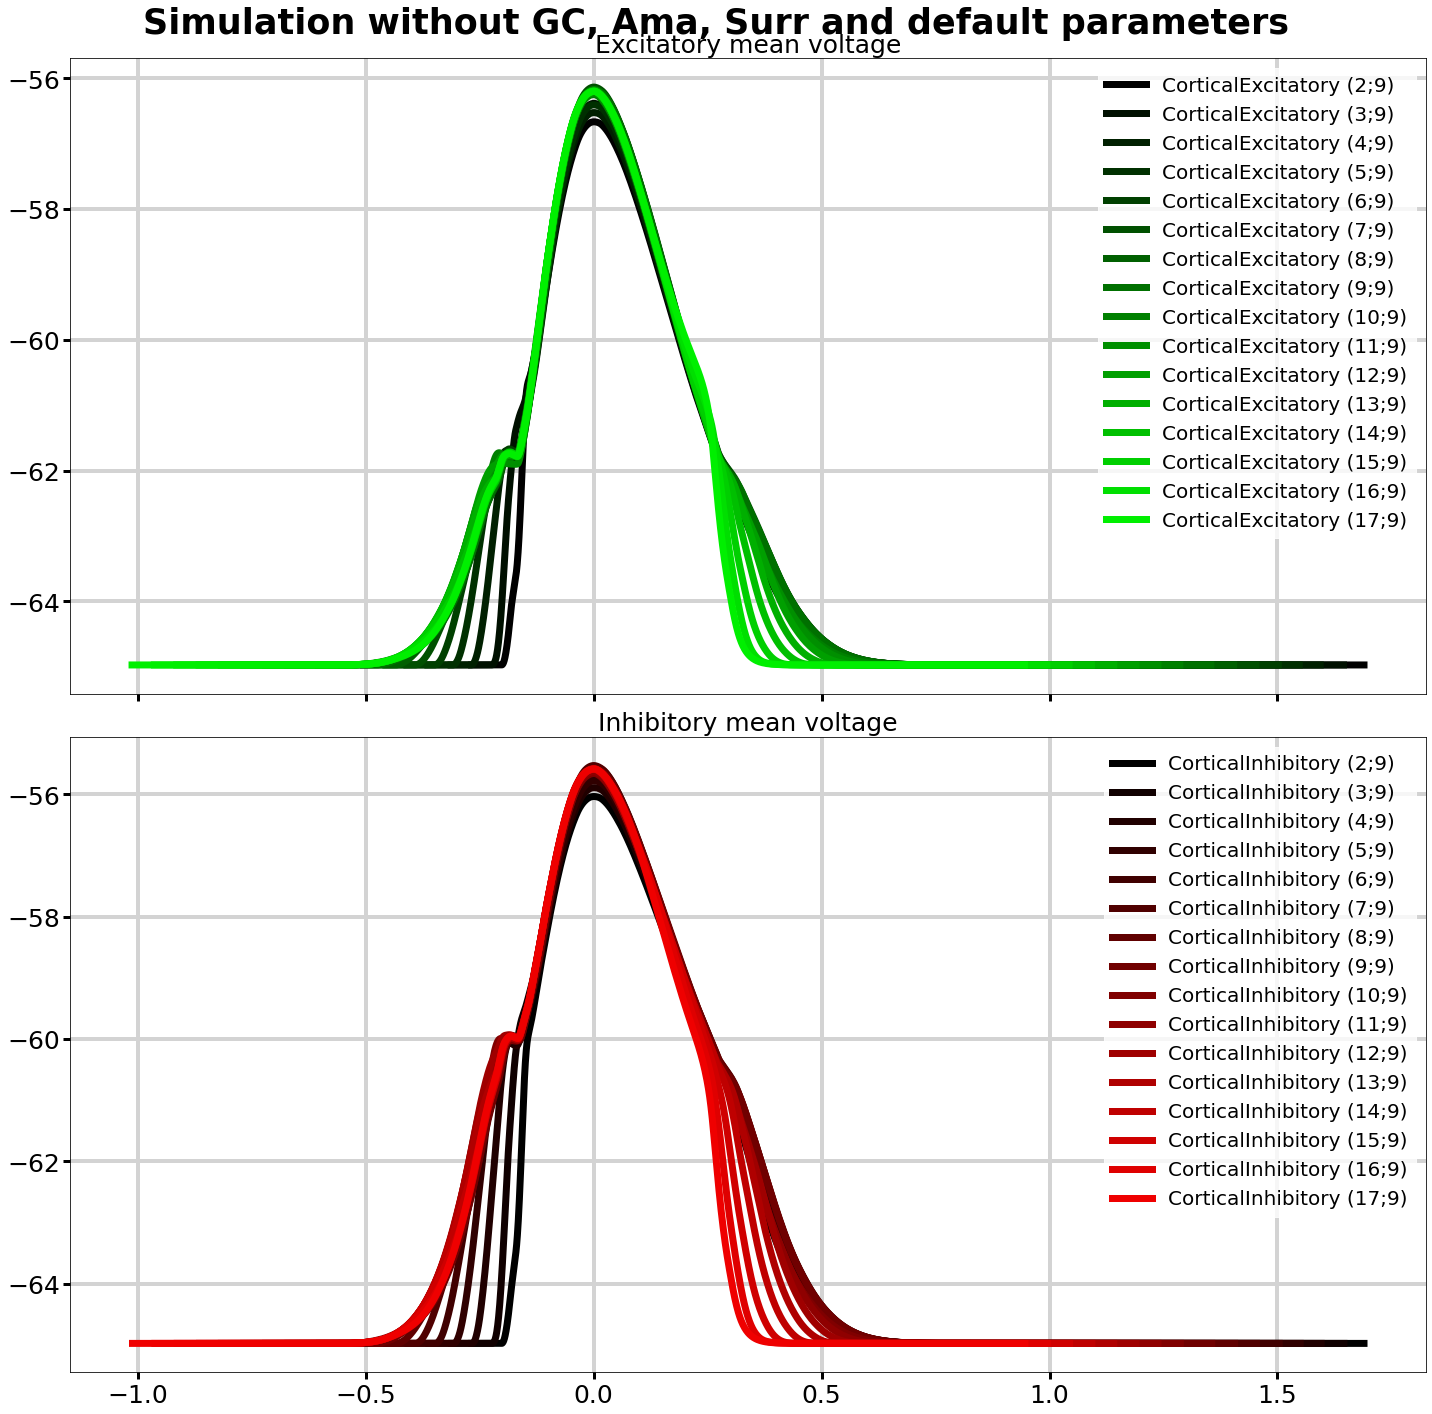

In [13]:
%matplotlib inline
importlib.reload(gdf)
importlib.reload(fg)

path = "/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/all_cells_31x31_0.0244_noGC_noAma_noSurr_extdrive0,002_VC300_4f.csv"

df = gdf.GraphDF(path,0.0233,60,20,20)

df = df.crop(0.09)
df = df.isolate_dataframe_byoutputs("muVn")
num_exc = ",".join([str(i) for i in range(1249,1569,20)])
num_inh = ",".join([str(i) for i in range(1649,1969,20)])
exc = df.isolate_dataframe_columns_bynum(num_exc)
inh = df.isolate_dataframe_columns_bynum(num_inh)
inh_c=inh.tmax_centering_df()
exc_c=exc.tmax_centering_df()

list_df = [exc_c, inh_c]

params_fig = dict(wspace=0.2,hspace=0.4,height_ratios=[1,1],width_ratios=[1,1])

info_fig = {"title":"Simulation without GC, Ama, Surr and default parameters","subtitles":["Excitatory mean voltage","Inhibitory mean voltage"],"xlabel":"Time (s)","ylabel":["Mean voltage (mV)","Mean voltage (mV)"],
"sharex":True,"sharey":False}

font_size = {"main_title":35, "subtitle":25, "xlabel":25, "ylabel":25, "g_xticklabel":25, "g_yticklabel":25, "legend":20}

params_plot = {"grid_color":"lightgray","grid_width":4,"ticklength":7,"tickwidth":3, 
               "plots_color":[[(0, i/exc.data.shape[1], 0) for i in range(0,exc.data.shape[1],1)],[(i/exc.data.shape[1], 0, 0) for i in range(0,exc.data.shape[1],1)]]}


f = gfg.graphFigure(list_df,2,1,20,20,dict_info_fig=info_fig, dict_font_size=font_size,dict_params_plot=params_plot)
f.set_figure_legend((1,2), fontsize=20)
plt.tight_layout()
plt.savefig("/user/jemonet/home/Documents/These/Code/Graphes/figure_lib/tests/results_tests/graphFigure/graphe_centré_pic.png")

### Graphe VSDI centré sur le pic

In [24]:
%matplotlib qt
importlib.reload(gdf)
importlib.reload(fg)

path = "/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/31x31_newCorrGaussian/all_cells_31x31_dt0,0244_noGC_noAma_noSurr_extdrive0,002_VC300_LexLinhSpeedCorr_3f.csv"

df = gdf.GraphDF(path,0.0244,60,20,20)

df = df.crop(0.09)
df = df.isolate_dataframe_byoutputs("muVn")
num_exc = ",".join([str(i) for i in range(1249,1569,20)])
num_inh = ",".join([str(i) for i in range(1649,1969,20)])
exc = df.isolate_dataframe_columns_bynum(num_exc)
inh = df.isolate_dataframe_columns_bynum(num_inh)
# exc = df.isolate_dataframe_bytype("CorticalExcitatory")
# inh = df.isolate_dataframe_bytype("CorticalInhibitory")
exc.data = (abs((exc.data - exc.data.iloc[0].mean())) / abs(exc.data.iloc[0].mean()))
inh.data = (abs((inh.data - inh.data.iloc[0].mean())) / abs(inh.data.iloc[0].mean()))
# exc.data = ((exc.data - exc.data.iloc[0].mean()) / exc.data.iloc[0].mean())
# inh.data = ((inh.data - inh.data.iloc[0].mean()) / inh.data.iloc[0].mean())

col_exc_rename = {exc.data.columns[i]:f"CorticalColumn ({i}) vsdi" for i in range(exc.data.columns.shape[0])}
col_inh_rename = {inh.data.columns[i]:f"CorticalColumn ({i}) vsdi" for i in range(exc.data.columns.shape[0])}
exc.data = exc.data.rename(columns=col_exc_rename)
inh.data = inh.data.rename(columns=col_inh_rename)

vsdi = exc.copy()
vsdi.data=exc.data*0.8+inh.data*0.2
vsdi_c=vsdi.tmax_centering_df()

list_df = [vsdi_c]

params_fig = dict(wspace=0.2,hspace=0.4,height_ratios=[1,1],width_ratios=[1,1])

info_fig = {"title":"Simulation without GC, Ama, Surr and 31x31 grid cell","subtitles":["VSDI in function of time"],"xlabel":"Time (s)","ylabel":"VSDI",
"sharex":True,"sharey":False}

font_size = {"main_title":35, "subtitle":25, "xlabel":25, "ylabel":25, "g_xticklabel":25, "g_yticklabel":25, "legend":20}

params_plot = {"grid_color":"lightgray","grid_width":4,"ticklength":7,"tickwidth":3, 
               "plots_color":[[(0, 0, (i/(exc.data.shape[1]/2))) if i<exc.data.shape[1]/2 else (0, i/(exc.data.shape[1]/2) - 1, 1.0) for i in range(0,exc.data.shape[1],1)]]}

# params_plot = {"grid_color":"lightgray","grid_width":4,"ticklength":7,"tickwidth":3, 
#                "plots_color":[[(0, i/exc.data.shape[1], i/exc.data.shape[1]) for i in range(0,exc.data.shape[1]+1,1)]]}

f = gfg.graphFigure(list_df,1,1,20,20,dict_info_fig=info_fig, dict_font_size=font_size,dict_params_plot=params_plot)
f.set_figure_legend((1,), fontsize=25)
f.ax.legend([f"{round(i*0.5166667,2)} deg" for i in range(len(vsdi_c))],fontsize=25)
plt.tight_layout()
#plt.savefig("/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/31x31_newCorrGaussian/graphe_centré_pic_vsdi.png")


-- Default values taken for figure parameters --
<class 'IndexError'>
/!\/!\ Number of subfigures to legend superior to real number of subfigures /!\/!\


### Graphe STTP et latence

all_cells_31x31_dt0,0244_noGC_noAma_noSurr_extdrive0,002_VC300_LexcSpeedCorr_3f.csv
31x31 0.0244 3 6
/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/31x31_newCorrGaussian/STTP_latency_speedStim6_all_cells_31x31_dt0,0244_noGC_noAma_noSurr_extdrive0,002_VC300_LexcSpeedCorr_3f.csv.png
all_cells_31x31_dt0,0244_noGC_noAma_noSurr_extdrive0,002_VC300_LexLinhSpeedCorr_3f.csv
31x31 0.0244 3 6
/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/31x31_newCorrGaussian/STTP_latency_speedStim6_all_cells_31x31_dt0,0244_noGC_noAma_noSurr_extdrive0,002_VC300_LexLinhSpeedCorr_3f.csv.png
all_cells_31x31_dt0,0244_noGC_noAma_noSurr_extdrive0,002_VC300_3f.csv
31x31 0.0244 3 6
/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/31x31_newCorrGaussian/STTP_latency_speedStim6_all_

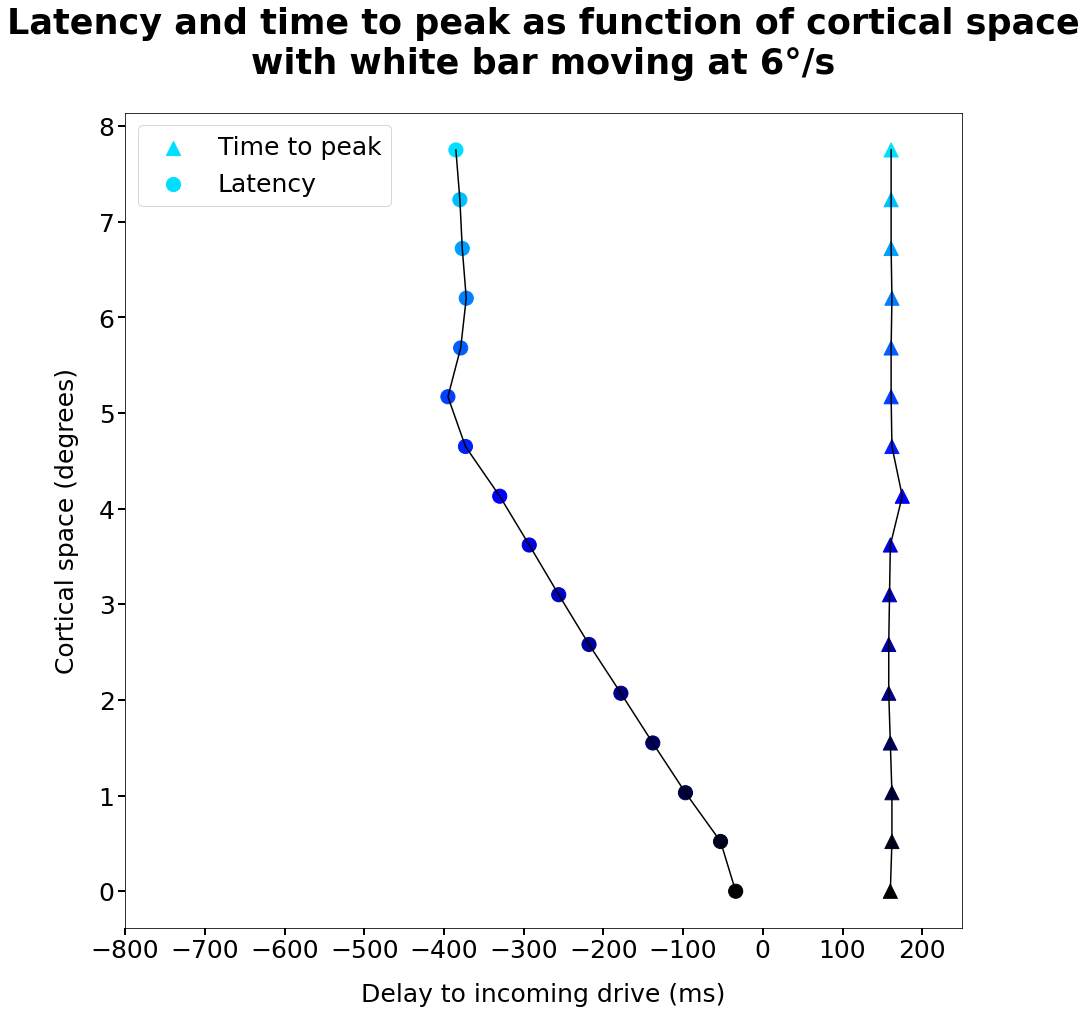

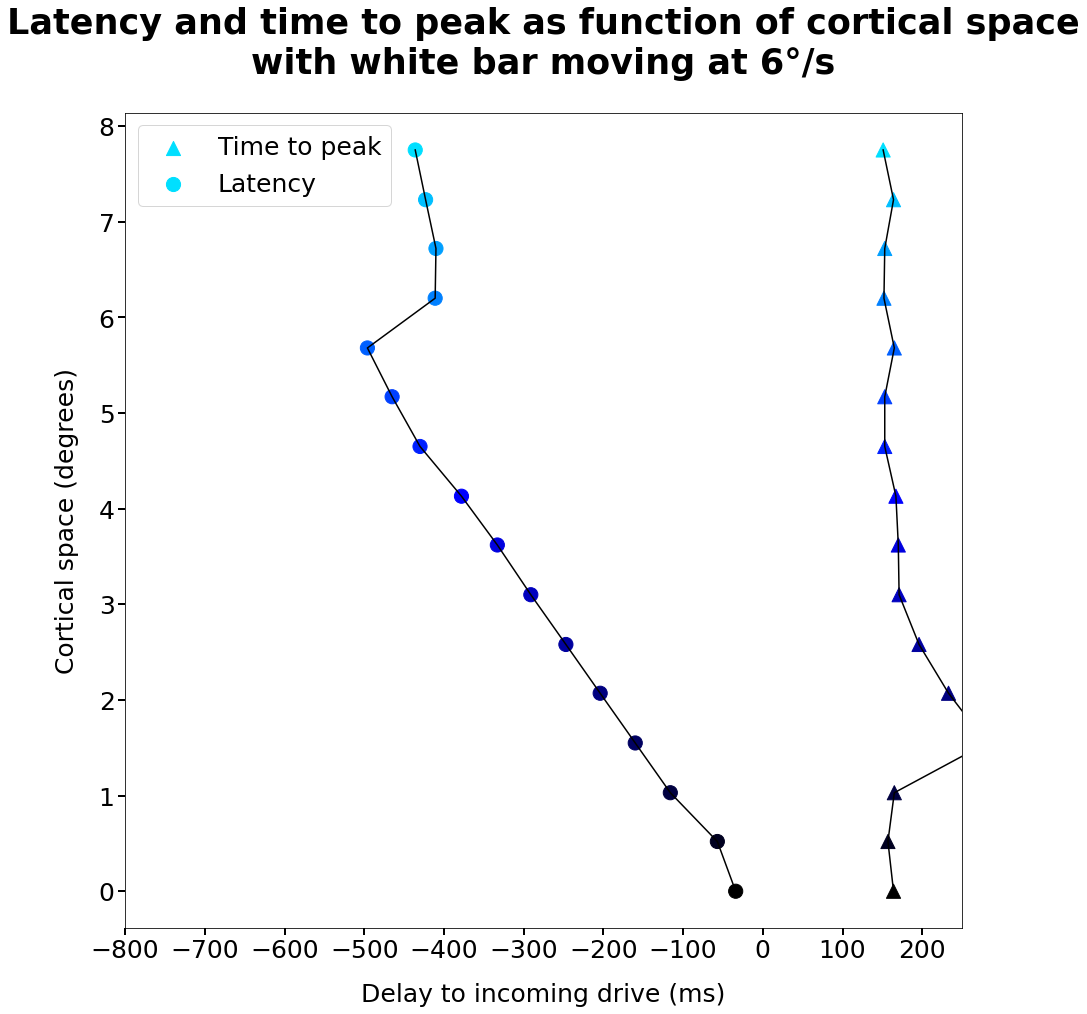

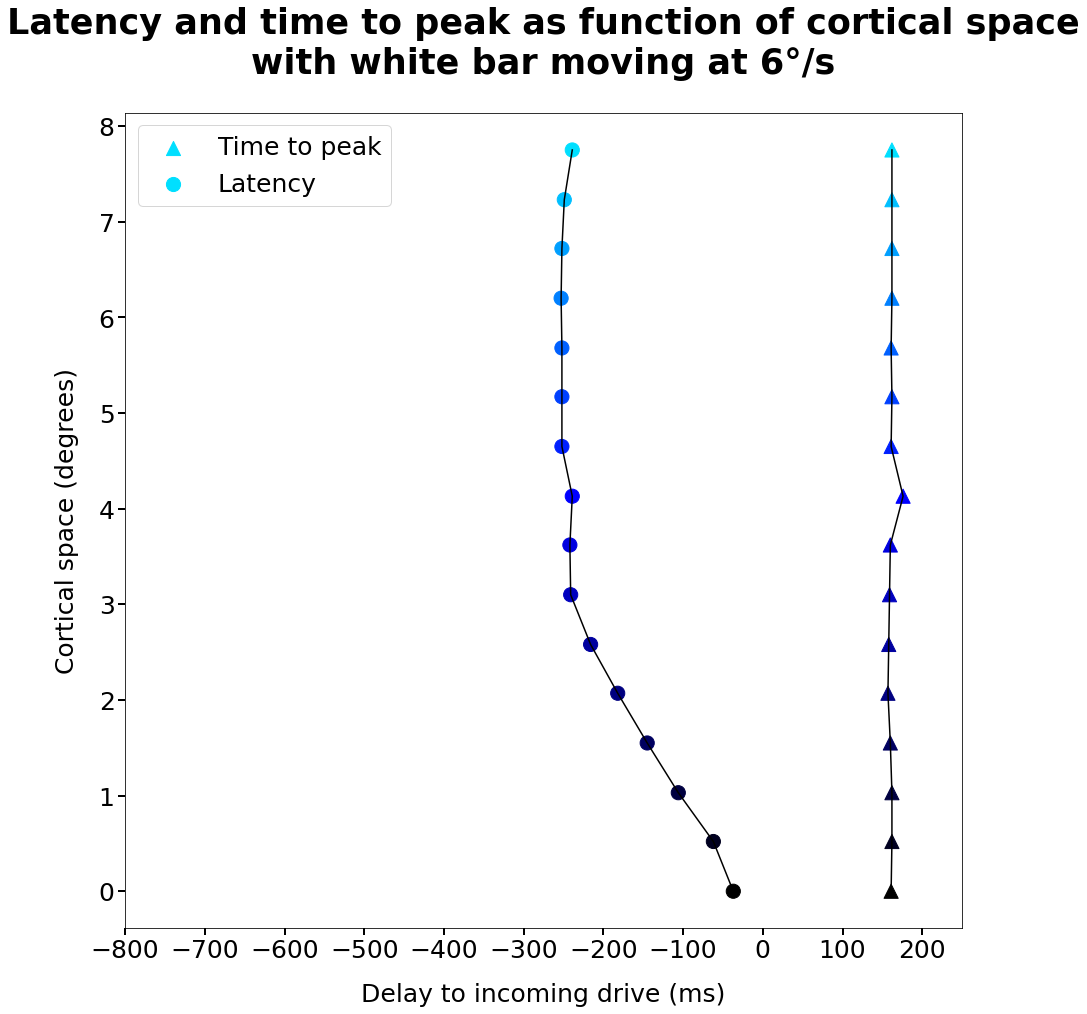

In [20]:
%matplotlib inline

# path_dir = "/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/stim_speed"
path_dir = "/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/31x31_newCorrGaussian"

re_files = re.compile(r"[0-9]{1,3}x[0-9]{1,3}_dt[01],[0-9]{1,7}.*_[0-9]{1,3}f.csv")
re_size = re.compile(r"[0-9]{1,3}x[0-9]{1,3}")
re_dt =re.compile(r"dt[01],[0-9]{1,7}")
re_n_frame = re.compile(r"[0-9]{1,3}f")

files = [f for f in os.listdir(path_dir) if isfile(join(path_dir,f)) and re_files.findall(f) != []]
files.sort(key = lambda x : float(re_dt.findall(x)[0][2:].replace(",",".")), reverse=True)

list_df_latence = []
list_df_sttp = []

for file in files:
    path_load = f"{path_dir}/{file}"
    size = re_size.findall(file)[0][:]
    dt = float(re_dt.findall(file)[0][2:].replace(",","."))
    n_frame = int(re_n_frame.findall(file)[0][:-1])
    speed_stim = round(1.8/(43*dt)*10/3)
    #path_out = f"{path_dir}/STTP_latency_speedStim{speed_stim}_dt{dt}.png"
    path_out = f"{path_dir}/STTP_latency_speedStim{speed_stim}_{file}.png"
    
    if dt != 0.14:
        print(file)
        print(size, dt, n_frame, speed_stim)
        print(path_out)

        df = gdf.GraphDF(path_load,dt,60,20,20)

        # Calcul valeurs rétine
        df = df.crop(df.dt*n_frame)
        df_ret = df.isolate_dataframe_byoutputs("FiringRate")
        num_ret = ",".join([str(i) for i in range(849,1169,20)])
        df_ret = df_ret.isolate_dataframe_columns_bynum(num_ret)

        # Calcul VSDI
        df_muV = df.isolate_dataframe_byoutputs("muVn")
        num_exc = ",".join([str(i) for i in range(1249,1569,20)])
        num_inh = ",".join([str(i) for i in range(1649,1969,20)])
        exc = df_muV.isolate_dataframe_columns_bynum(num_exc)
        inh = df_muV.isolate_dataframe_columns_bynum(num_inh)
        # exc = df.isolate_dataframe_bytype("CorticalExcitatory")
        # inh = df.isolate_dataframe_bytype("CorticalInhibitory")
        exc.data = (abs((exc.data - exc.data.iloc[0].mean())) / abs(exc.data.iloc[0].mean()))
        inh.data = (abs((inh.data - inh.data.iloc[0].mean())) / abs(inh.data.iloc[0].mean()))
        # exc.data = ((exc.data - exc.data.iloc[0].mean()) / exc.data.iloc[0].mean())
        # inh.data = ((inh.data - inh.data.iloc[0].mean()) / inh.data.iloc[0].mean())

        col_exc_rename = {exc.data.columns[i]:f"CorticalColumn ({i}) vsdi" for i in range(exc.data.columns.shape[0])}
        col_inh_rename = {inh.data.columns[i]:f"CorticalColumn ({i}) vsdi" for i in range(exc.data.columns.shape[0])}
        exc.data = exc.data.rename(columns=col_exc_rename)
        inh.data = inh.data.rename(columns=col_inh_rename)

        vsdi = exc.copy()
        vsdi.data=exc.data*0.8+inh.data*0.2



        # Calcul liste de temps de début d'activation de chaque cellules ganglionnaires (t0)
        dFRdt = compute_derivate(df_ret)
        ret_f = df_ret.data[(dFRdt>0.1) & (df_ret.data > 5)]
        list_inflex_ret = [round(ret_f.iloc[:,i].dropna().index[0],3) for i in range(len(ret_f.columns))]

        # Calcul liste des temps des pics de chaque cellule (t1)
        list_max_vsdi = [col.tmax for col in vsdi.list_col]


        # Calcul liste de temps de début d'activation de chaque colonnes corticales (t2)
        dVSDIdt = compute_derivate(vsdi)
        vsdi_f = vsdi.data[(dVSDIdt>0.1) & (vsdi.data > 0.005)]
        list_inflex_vsdi = [round(vsdi_f.iloc[:,i].dropna().index[0],3) for i in range(len(vsdi_f.columns))]

        # Calcul de la STTP
        list_STTP = [(list_max_vsdi[i]-list_inflex_ret[i])*1000 for i in range(len(list_max_vsdi))]

        list_latence = [(list_inflex_vsdi[i]-list_inflex_ret[i])*1000 for i in range(len(list_inflex_vsdi))]

        # Plot
        list_color = [(0, 0, (i/(vsdi.data.shape[1]/2))) if i<vsdi.data.shape[1]/2 else (0, i/(vsdi.data.shape[1]/2) - 1, 1.0) for i in range(0,vsdi.data.shape[1],1)]
        
        delta_x = 0.5166667
        df_STTP = pd.DataFrame([round(i*delta_x,2) for i in range(16)], index=list_STTP)
        df_latence = pd.DataFrame([round(i*delta_x,2) for i in range(16)], index=list_latence)
        list_df_latence.append(df_latence)
        list_df_sttp.append(df_STTP)

        fig,ax = plt.subplots(1,1,figsize=(15,15))
        ax.plot(df_STTP, c="black")
        # ax.plot(df_STTP, marker="^", markersize=12, label="Time to peak")
        plt.scatter(df_STTP.index, df_STTP.iloc[:,0], label="Time to peak", marker='^', s=200, c=list_color)

        ax.plot(df_latence, c="black")
        # ax.plot(df_latence, marker="o", markersize=12, label="Latency")
        plt.scatter(df_latence.index, df_latence.iloc[:,0], label="Latency", marker="o", s=200, c=list_color)

        leg = ax.legend(fontsize=25)
        leg.legendHandles[0].set_color(list_color[-1])
        leg.legendHandles[1].set_color(list_color[-1])
        ax.set_title(f"Latency and time to peak as function of cortical space\nwith white bar moving at {speed_stim}°/s", fontsize=35, fontweight="bold", pad=40)
        ax.set_xlabel("Delay to incoming drive (ms)", fontsize=25,labelpad=20)
        ax.set_ylabel("Cortical space (degrees)", fontsize=25,labelpad=20)
        ax.xaxis.set_ticks(np.array([i for i in range(-800,400,100)]))
        ax.tick_params(axis="x", which="both", labelsize=25, color="black", length=7, width=2)
        ax.tick_params(axis="y", which="both", labelsize=25, color="black", length=7, width=2)
        ax.set_xlim(-800,250)
        #plt.savefig(path_out, bbox_inches='tight' )

31x31 0.0465 7 3
/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/stim_speed/STTP_latency_speedStim3_dt0.0465.png
31x31 0.0233 4 6
/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/stim_speed/STTP_latency_speedStim6_dt0.0233.png
31x31 0.0155 18 9
/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/stim_speed/STTP_latency_speedStim9_dt0.0155.png
31x31 0.0116 6 12
/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/stim_speed/STTP_latency_speedStim12_dt0.0116.png
31x31 0.0093 14 15
/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/stim_speed/STTP_latency_speedStim15_dt0.0093.png
31x31 0.00775 35 18
/use

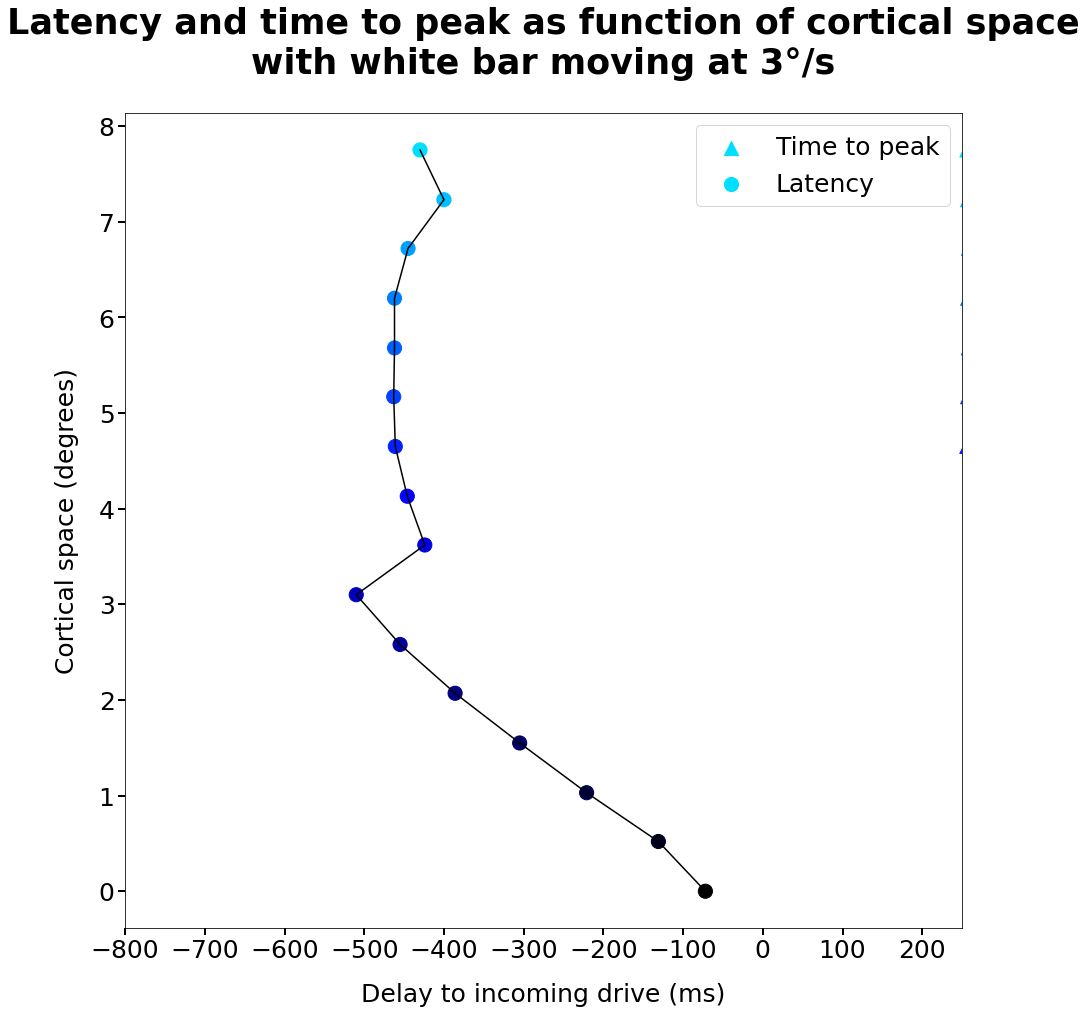

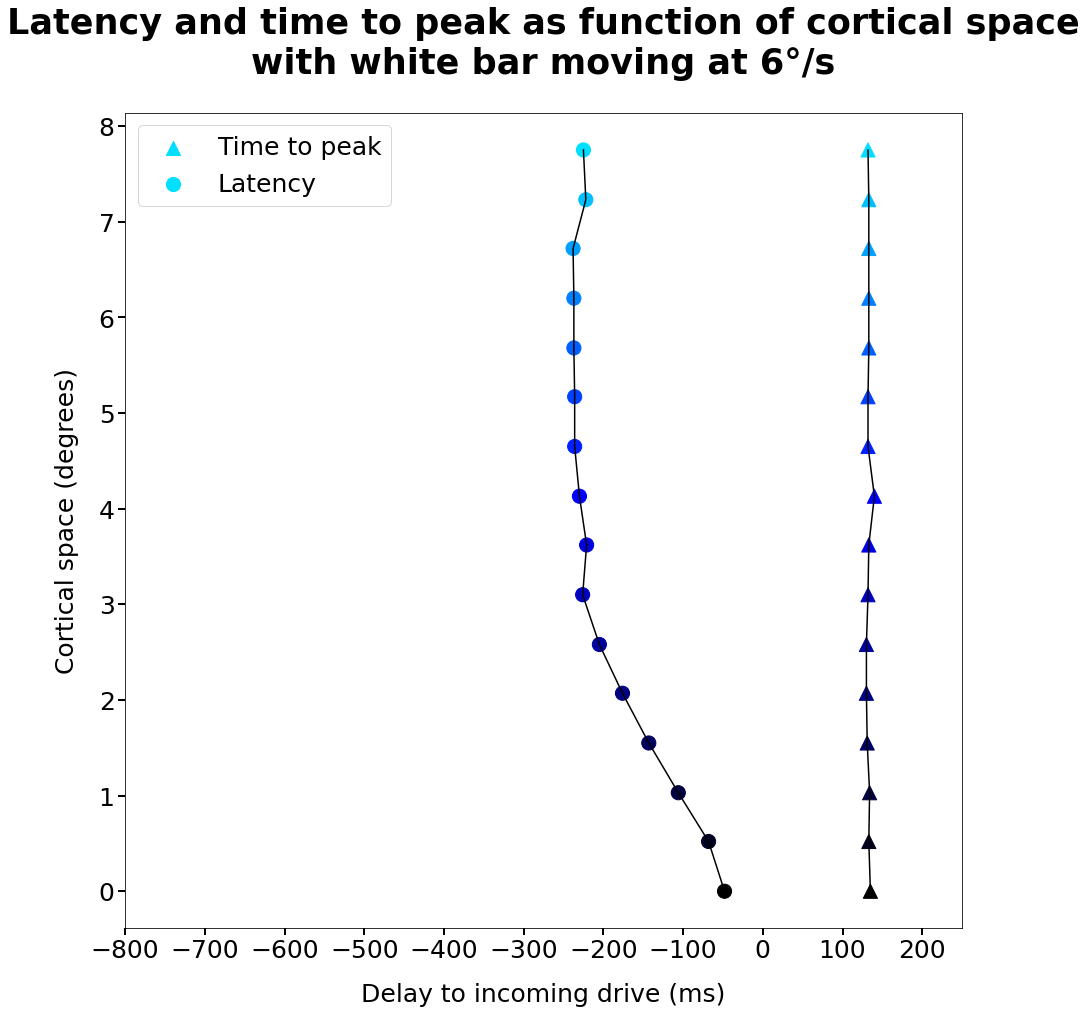

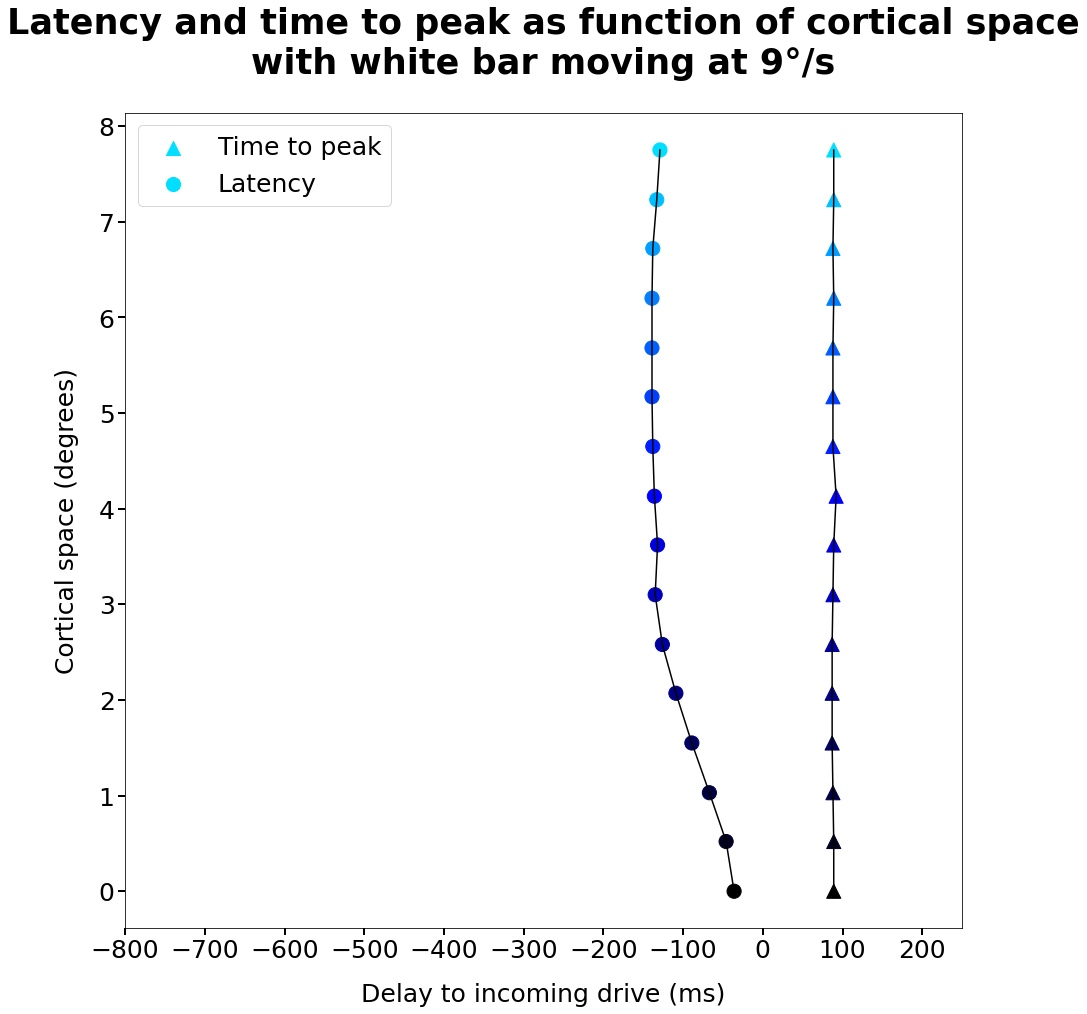

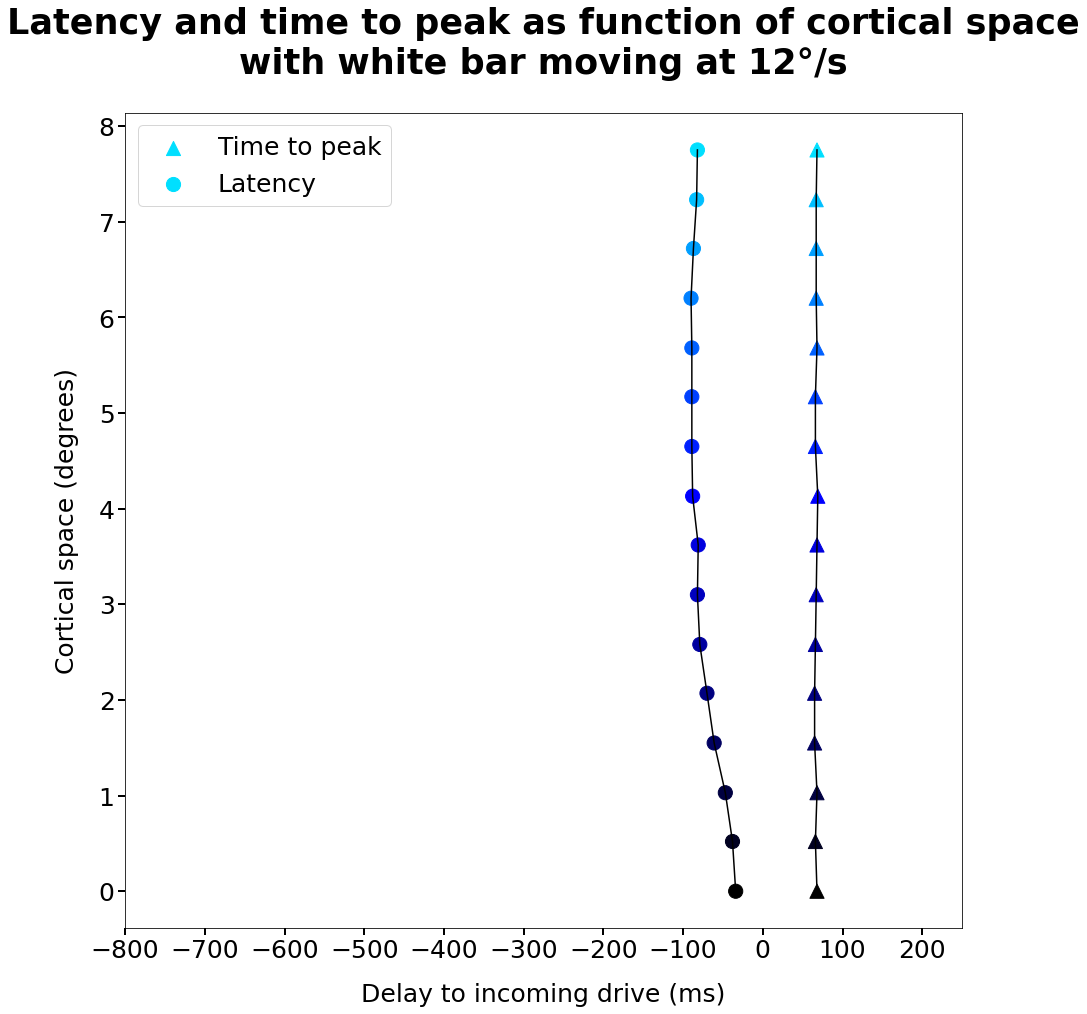

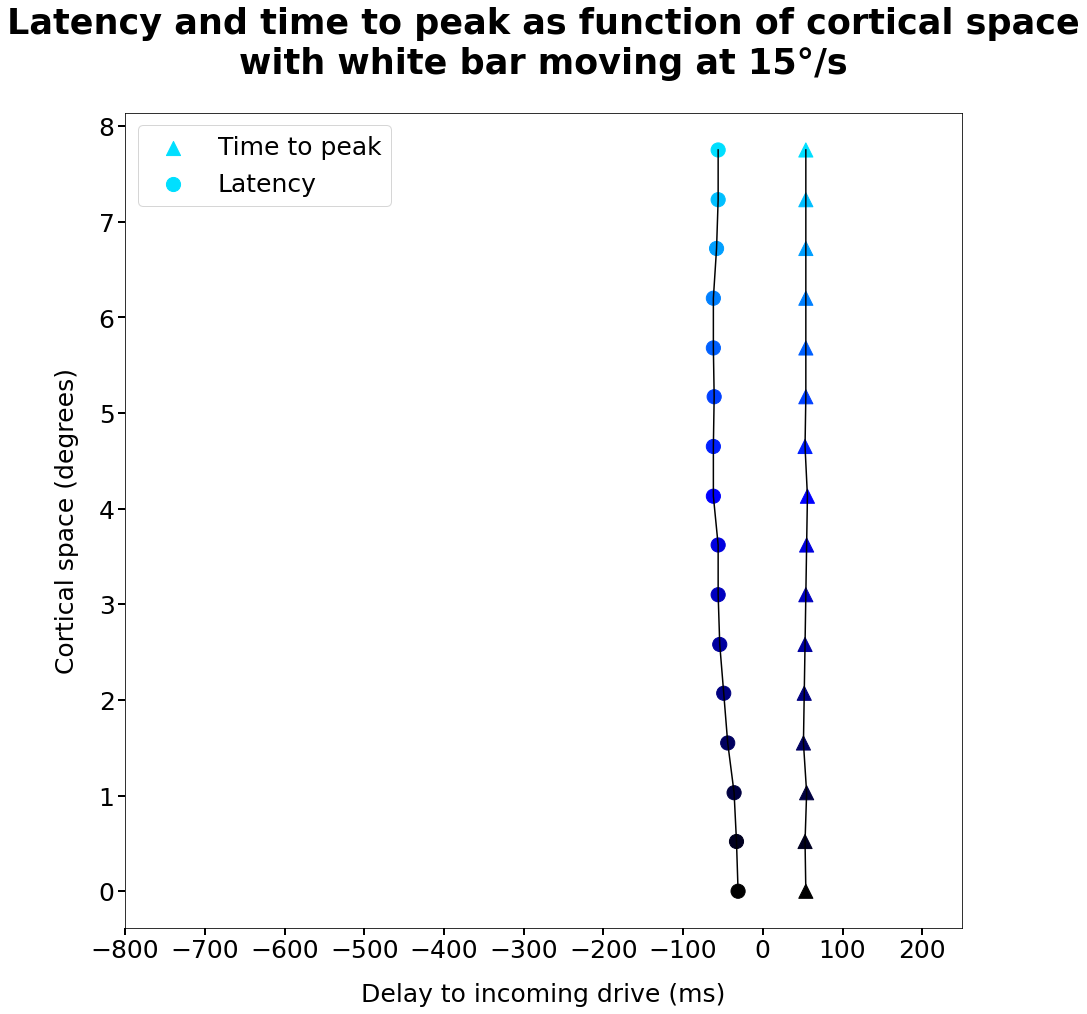

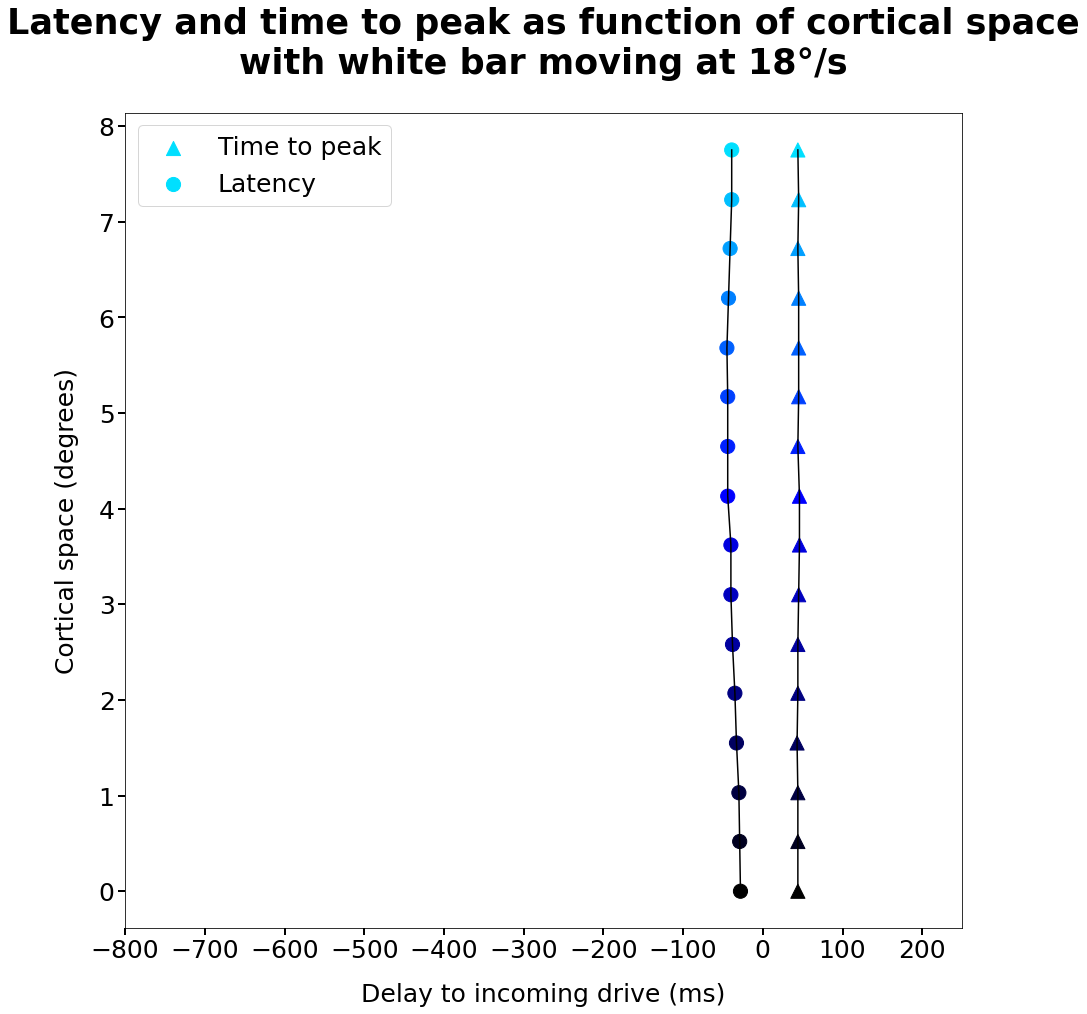

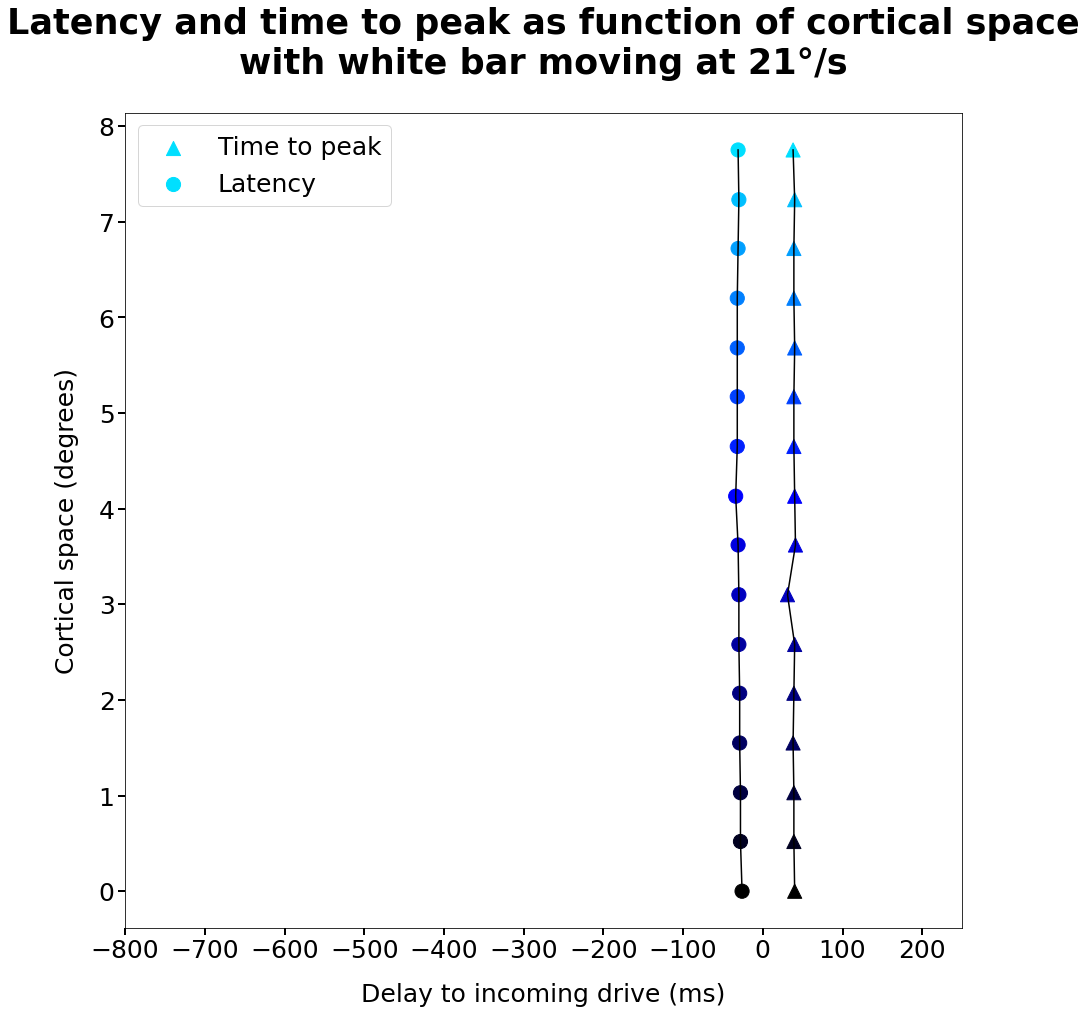

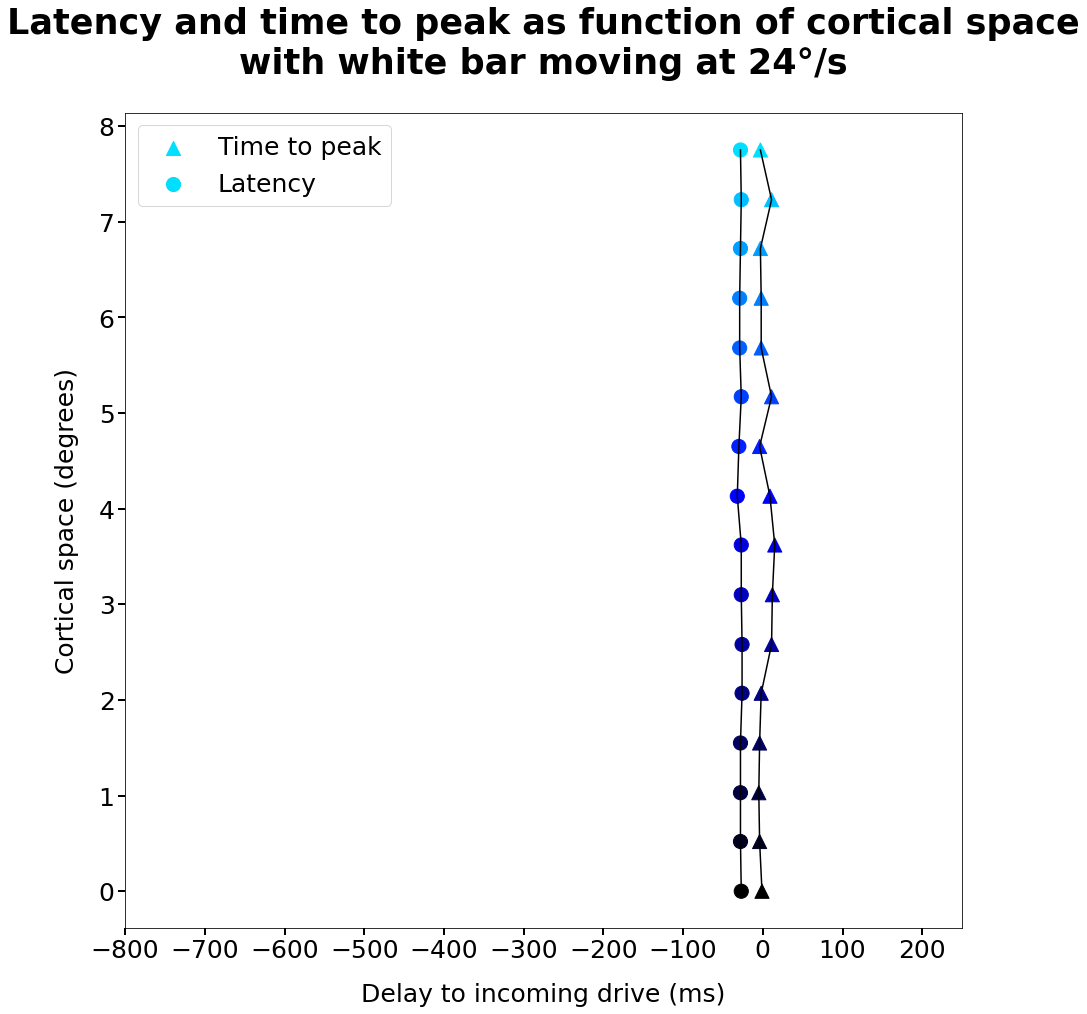

In [133]:
%matplotlib inline

# path_dir = "/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/stim_speed"
path_dir = "/user/jemonet/home/Documents/These/Data Macular/Retino_cortical_fastmovingBar/(current) corrections_retinocortical_branch/Cortex/31x31_newCorrGaussian"

re_files = re.compile(r"[0-9]{1,3}x[0-9]{1,3}_dt[01],[0-9]{1,7}.*_[0-9]{1,3}f.csv")
re_size = re.compile(r"[0-9]{1,3}x[0-9]{1,3}")
re_dt =re.compile(r"dt[01],[0-9]{1,7}")
re_n_frame = re.compile(r"[0-9]{1,3}f")

files = [f for f in os.listdir(path_dir) if isfile(join(path_dir,f)) and re_files.findall(f) != []]
files.sort(key = lambda x : float(re_dt.findall(x)[0][2:].replace(",",".")), reverse=True)

list_df_latence = []
list_df_sttp = []

for file in files:
    path_load = f"{path_dir}/{file}"
    size = re_size.findall(file)[0][:]
    dt = float(re_dt.findall(file)[0][2:].replace(",","."))
    n_frame = int(re_n_frame.findall(file)[0][:-1])
    speed_stim = round(1.8/(43*dt)*10/3)
    path_out = f"{path_dir}/STTP_latency_speedStim{speed_stim}_dt{dt}.png"
    
    if dt != 0.14:         
        print(size, dt, n_frame, speed_stim)
        print(path_out)

        df = gdf.GraphDF(path_load,dt,60,20,20)

        # Calcul valeurs rétine
        df = df.crop(df.dt*n_frame)
        df_ret = df.isolate_dataframe_byoutputs("FiringRate")
        num_ret = ",".join([str(i) for i in range(849,1169,20)])
        df_ret = df_ret.isolate_dataframe_columns_bynum(num_ret)

        # Calcul VSDI
        df_muV = df.isolate_dataframe_byoutputs("muVn")
        num_exc = ",".join([str(i) for i in range(1249,1569,20)])
        num_inh = ",".join([str(i) for i in range(1649,1969,20)])
        exc = df_muV.isolate_dataframe_columns_bynum(num_exc)
        inh = df_muV.isolate_dataframe_columns_bynum(num_inh)
        # exc = df.isolate_dataframe_bytype("CorticalExcitatory")
        # inh = df.isolate_dataframe_bytype("CorticalInhibitory")
        exc.data = (abs((exc.data - exc.data.iloc[0].mean())) / abs(exc.data.iloc[0].mean()))
        inh.data = (abs((inh.data - inh.data.iloc[0].mean())) / abs(inh.data.iloc[0].mean()))
        # exc.data = ((exc.data - exc.data.iloc[0].mean()) / exc.data.iloc[0].mean())
        # inh.data = ((inh.data - inh.data.iloc[0].mean()) / inh.data.iloc[0].mean())

        col_exc_rename = {exc.data.columns[i]:f"CorticalColumn ({i}) vsdi" for i in range(exc.data.columns.shape[0])}
        col_inh_rename = {inh.data.columns[i]:f"CorticalColumn ({i}) vsdi" for i in range(exc.data.columns.shape[0])}
        exc.data = exc.data.rename(columns=col_exc_rename)
        inh.data = inh.data.rename(columns=col_inh_rename)

        vsdi = exc.copy()
        vsdi.data=exc.data*0.8+inh.data*0.2



        # Calcul liste de temps de début d'activation de chaque cellules ganglionnaires (t0)
        dFRdt = compute_derivate(df_ret)
        ret_f = df_ret.data[(dFRdt>0.1) & (df_ret.data > 5)]
        list_inflex_ret = [round(ret_f.iloc[:,i].dropna().index[0],3) for i in range(len(ret_f.columns))]

        # Calcul liste des temps des pics de chaque cellule (t1)
        list_max_vsdi = [col.tmax for col in vsdi.list_col]


        # Calcul liste de temps de début d'activation de chaque colonnes corticales (t2)
        dVSDIdt = compute_derivate(vsdi)
        vsdi_f = vsdi.data[(dVSDIdt>0.1) & (vsdi.data > 0.005)]
        list_inflex_vsdi = [round(vsdi_f.iloc[:,i].dropna().index[0],3) for i in range(len(vsdi_f.columns))]

        # Calcul de la STTP
        list_STTP = [(list_max_vsdi[i]-list_inflex_ret[i])*1000 for i in range(len(list_max_vsdi))]

        list_latence = [(list_inflex_vsdi[i]-list_inflex_ret[i])*1000 for i in range(len(list_inflex_vsdi))]

        # Plot
        list_color = [(0, 0, (i/(vsdi.data.shape[1]/2))) if i<vsdi.data.shape[1]/2 else (0, i/(vsdi.data.shape[1]/2) - 1, 1.0) for i in range(0,vsdi.data.shape[1],1)]
        
        delta_x = 0.5166667
        df_STTP = pd.DataFrame([round(i*delta_x,2) for i in range(16)], index=list_STTP)
        df_latence = pd.DataFrame([round(i*delta_x,2) for i in range(16)], index=list_latence)
        list_df_latence.append(df_latence)
        list_df_sttp.append(df_STTP)

        fig,ax = plt.subplots(1,1,figsize=(15,15))
        ax.plot(df_STTP, c="black")
        # ax.plot(df_STTP, marker="^", markersize=12, label="Time to peak")
        plt.scatter(df_STTP.index, df_STTP.iloc[:,0], label="Time to peak", marker='^', s=200, c=list_color)

        ax.plot(df_latence, c="black")
        # ax.plot(df_latence, marker="o", markersize=12, label="Latency")
        plt.scatter(df_latence.index, df_latence.iloc[:,0], label="Latency", marker="o", s=200, c=list_color)

        leg = ax.legend(fontsize=25)
        leg.legendHandles[0].set_color(list_color[-1])
        leg.legendHandles[1].set_color(list_color[-1])
        ax.set_title(f"Latency and time to peak as function of cortical space\nwith white bar moving at {speed_stim}°/s", fontsize=35, fontweight="bold", pad=40)
        ax.set_xlabel("Delay to incoming drive (ms)", fontsize=25,labelpad=20)
        ax.set_ylabel("Cortical space (degrees)", fontsize=25,labelpad=20)
        ax.xaxis.set_ticks(np.array([i for i in range(-800,400,100)]))
        ax.tick_params(axis="x", which="both", labelsize=25, color="black", length=7, width=2)
        ax.tick_params(axis="y", which="both", labelsize=25, color="black", length=7, width=2)
        ax.set_xlim(-800,250)
        #plt.savefig(path_out, bbox_inches='tight' )

In [125]:
list_sttp = []
list_inflex_point = []
list_latency_slope = []
list_s_latency = []

list_speed = [i for i in range(3,25,3)]
for i in range(0,len(list_df_latence)):
    speed = list_speed[i]
    print(f"### SPEED : {speed}°/s ###")
    df_latence = list_df_latence[i]    
    df_sttp = list_df_sttp[i]

    # Calcul STTP mean
    sttp = df_sttp.reset_index().iloc[:,0].mean()

    # Calcul Cortical extensiondf_latence
    df_latence = df_latence.reset_index().rename(columns={0:"Cort. Extent", "index":"Latence"})
    df_latence.loc[:,"Latence"] = df_latence.loc[:,"Latence"]/1000
    dlatencedt = compute_derivate_df(df_latence.set_index("Latence"))
    dlatencedt = dlatencedt.rename(columns = {"Cort. Extent":"Derivate extent"}).reset_index().drop(columns="Latence")
    df_lat_dlat = df_latence.join(dlatencedt).set_index("Latence")
    #display(df_lat_dlat)

    list_diff_lat = [abs(df_lat_dlat.loc[:,"Derivate extent"].iloc[i] - df_lat_dlat.loc[:,"Derivate extent"].iloc[i-1]) for i in range(1,df_lat_dlat.shape[0])]
    #print(list_diff_lat)
    inflex_index = list_diff_lat.index(max(list_diff_lat)) + 1
    inflex_point = df_lat_dlat.loc[:,"Cort. Extent"].iloc[inflex_index]
    
    # for i in range(1,df_lat_dlat.shape[0]):
    #     diff = abs(df_lat_dlat.loc[:,"Derivate latence"].iloc[i] - df_lat_dlat.loc[:,"Derivate latence"].iloc[i-1])
    #     print(diff)
    #     if diff > 20:
    #         inflex_point = df_lat_dlat.index[i]
    #         inflex_index = i
    #         print(f"POINT INFLEXION : {inflex_point}° // DIFF = {diff}")
    #         break
    #     if i == df_lat_dlat.shape[0]-1:
    #         print("No inflexion point found")
    #         inflex_point = None

    # Calcul Latency slope
    if inflex_point == None:
        latency_slope = np.NaN
        inflex_point = np.NaN
    else:
        latency_slope = df_lat_dlat.iloc[:inflex_index].loc[:,"Derivate extent"].mean()

    # Calcul Stationary Latency
    # s_latency = df_lat_dlat.iloc[inflex_index+1:].loc[:,"Latence"].mean()
    s_latency = df_lat_dlat.iloc[inflex_index+1:].index.to_series().mean()*1000

    
    # Append lists one col to each curve one col to each curve one col to each curve one col to each curve one col to each curve
    list_sttp.append(sttp)
    list_s_latency.append(s_latency)
    list_inflex_point.append(inflex_point)
    list_latency_slope.append(latency_slope)

    print(f"STTP : {sttp} ms\nInflexion Point : {inflex_point}°\nLatency Slope : {latency_slope} °/s\nStationary Latency : {s_latency} ms\n")

### SPEED : 3°/s ###
STTP : 262.1875 ms
Inflexion Point : 5.68°
Latency Slope : -101.13583374015171 °/s
Stationary Latency : -434.25 ms

### SPEED : 6°/s ###
STTP : 132.875 ms
Inflexion Point : 6.72°
Latency Slope : -290.31246154661926 °/s
Stationary Latency : -223.49999999999997 ms

### SPEED : 9°/s ###
STTP : 88.4375 ms
Inflexion Point : 6.2°
Latency Slope : -246.0884240587911 °/s
Stationary Latency : -133.33333333333334 ms

### SPEED : 12°/s ###
STTP : 66.9375 ms
Inflexion Point : 5.17°
Latency Slope : -230.2702991453025 °/s
Stationary Latency : -86.19999999999999 ms

### SPEED : 15°/s ###
STTP : 53.74999999999999 ms
Inflexion Point : 5.68°
Latency Slope : 3373605539048377.5 °/s
Stationary Latency : -58.00000000000001 ms

### SPEED : 18°/s ###
STTP : 44.5 ms
Inflexion Point : 5.68°
Latency Slope : -361.590909090909 °/s
Stationary Latency : -40.5 ms

### SPEED : 21°/s ###
STTP : 38.8125 ms
Inflexion Point : 7.23°
Latency Slope : -368.39285714285836 °/s
Stationary Latency : -31.000000

In [121]:
print("STTP : ", list_sttp)
print("STATIONNARY LATENCY : ", list_s_latency)
print("INFLEXION POINT : ", list_inflex_point)
print("LATENCY SLOPE : ", list_latency_slope)

STTP :  [262.1875, 132.875, 88.4375, 66.9375, 53.74999999999999, 44.5, 38.8125, 2.4375000000000018]
STATIONNARY LATENCY :  [-434.25, -223.49999999999997, -133.33333333333334, -86.19999999999999, -58.00000000000001, -40.5, -31.00000000000003, -28.000000000000007]
INFLEXION POINT :  [5.68, 6.72, 6.2, 5.17, 5.68, 5.68, 7.23, 1.55]
LATENCY SLOPE :  [-101.13583374015171, -290.31246154661926, -246.0884240587911, -230.2702991453025, 3373605539048377.5, -361.590909090909, -368.39285714285836, -2.4739773953022444e+16]


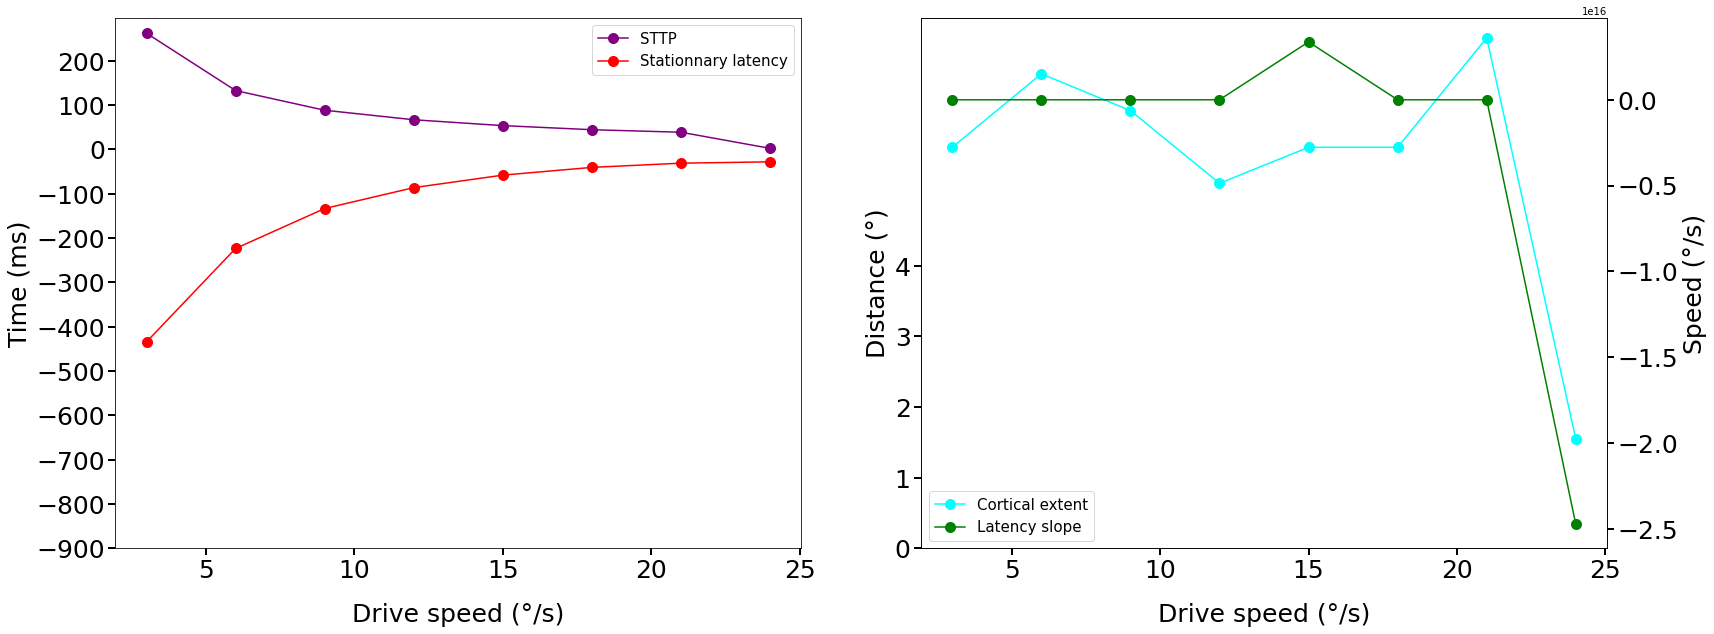

In [122]:
df_measures = pd.DataFrame.from_dict({"speed":list_speed,"STTP":list_sttp, "Stat. Latency":list_s_latency, "Inflexion Point":list_inflex_point, "Latency Slope":list_latency_slope}).set_index("speed")

fig,ax = plt.subplots(1,2,figsize=(25,10))
ax2 = ax[1].twinx()
ax[0].plot(df_measures.loc[:,["STTP"]], c="purple",marker="o", markersize=10,label="STTP")
ax[0].plot(df_measures.loc[:,["Stat. Latency"]], c="red",marker="o", markersize=10,label="Stationnary latency")
ax[1].plot(df_measures.loc[:,["Inflexion Point"]], c="cyan",marker="o", markersize=10,label="Cortical extent")
ax2.plot(df_measures.loc[:,["Latency Slope"]], c="green",marker="o", markersize=10,label="Latency slope")

ax[0].legend(fontsize=15)
lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax[1].legend(lines+lines2, labels+labels2, loc=0, fontsize=15)

ax[0].set_ylabel("Time (ms)", fontsize=25, labelpad=5)
ax[1].set_ylabel("Distance (°)", fontsize=25, labelpad=5)
ax2.set_ylabel("Speed (°/s)", fontsize=25, labelpad=5)

ax[0].yaxis.set_ticks(np.array([i for i in range(-900,300,100)]))
ax[1].yaxis.set_ticks(np.array([i for i in range(0,5,1)]))

for axe in [ax[0],ax[1],ax2]:
    axe.set_xlabel("Drive speed (°/s)", fontsize=25,labelpad=20)
# ax.set_title(f"Latency and time to peak as function of cortical space\nwith white bar moving at {speed_stim}°/s", fontsize=35, fontweight="bold", pad=40)
    axe.tick_params(axis="x", which="both", labelsize=25, color="black", length=7, width=2)
    axe.tick_params(axis="y", which="both", labelsize=25, color="black", length=7, width=2)
# ax.set_xlim(-800,250)
fig.tight_layout(pad=5)
# #plt.savefig(path_out, bbox_inches='tight' )

In [6]:
list_speed = [i for i in range(3,25,3)]
list_sttp = [262.1875, 132.875, 88.4375, 66.9375, 53.74999999999999, 44.5, 38.8125, 2.4375000000000018]
list_s_latency = [-443.6666666666667, -231.33333333333334, -135.88888888888889, -86.44444444444444, -59.16666666666668, -41.83333333333333, -31.750000000000004, -27.999999999999996]
list_inflex_point = [3.1, 3.1, 3.1, 3.1, 4.65, 4.65, 3.62, 4.65]
list_latency_slope = [-141.95450585013688, -57.27221807318895, -32.10418222554144, -15.647560368434158, -6.884283461953365, -3.550535225292506, -1.5176571001813688, -0.9698365280889537]

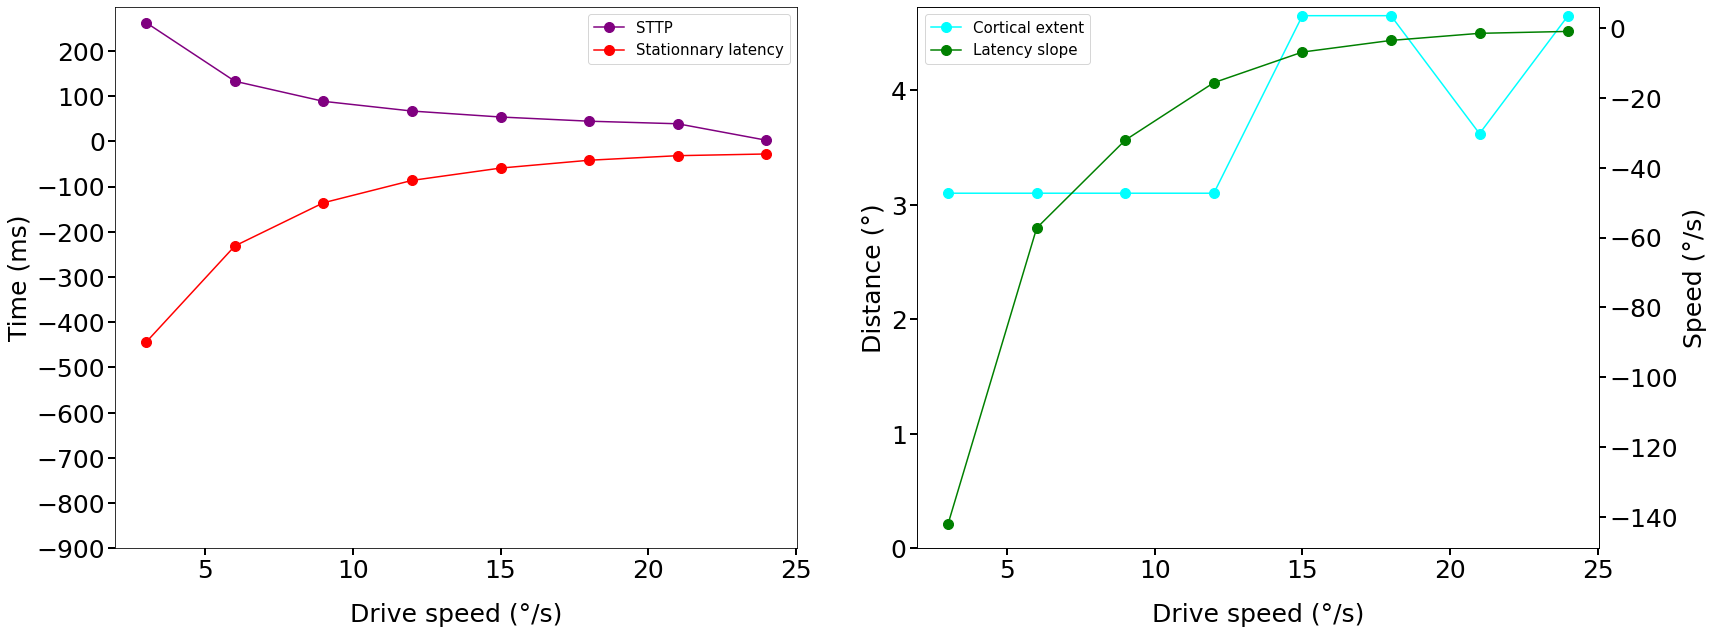

In [52]:
df_measures = pd.DataFrame.from_dict({"speed":list_speed,"STTP":list_sttp, "Stat. Latency":list_s_latency, "Inflexion Point":list_inflex_point, "Latency Slope":list_latency_slope}).set_index("speed")

fig,ax = plt.subplots(1,2,figsize=(25,10))
ax2 = ax[1].twinx()
ax[0].plot(df_measures.loc[:,["STTP"]], c="purple",marker="o", markersize=10,label="STTP")
ax[0].plot(df_measures.loc[:,["Stat. Latency"]], c="red",marker="o", markersize=10,label="Stationnary latency")
ax[1].plot(df_measures.loc[:,["Inflexion Point"]], c="cyan",marker="o", markersize=10,label="Cortical extent")
ax2.plot(df_measures.loc[:,["Latency Slope"]], c="green",marker="o", markersize=10,label="Latency slope")

ax[0].legend(fontsize=15)
lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax[1].legend(lines+lines2, labels+labels2, loc=0, fontsize=15)

ax[0].set_ylabel("Time (ms)", fontsize=25, labelpad=5)
ax[1].set_ylabel("Distance (°)", fontsize=25, labelpad=5)
ax2.set_ylabel("Speed (°/s)", fontsize=25, labelpad=5)

ax[0].yaxis.set_ticks(np.array([i for i in range(-900,300,100)]))
ax[1].yaxis.set_ticks(np.array([i for i in range(0,5,1)]))

for axe in [ax[0],ax[1],ax2]:
    axe.set_xlabel("Drive speed (°/s)", fontsize=25,labelpad=20)
# ax.set_title(f"Latency and time to peak as function of cortical space\nwith white bar moving at {speed_stim}°/s", fontsize=35, fontweight="bold", pad=40)
    axe.tick_params(axis="x", which="both", labelsize=25, color="black", length=7, width=2)
    axe.tick_params(axis="y", which="both", labelsize=25, color="black", length=7, width=2)
# ax.set_xlim(-800,250)
fig.tight_layout(pad=5)
# #plt.savefig(path_out, bbox_inches='tight' )

## Plots de la classe heatmapFigure

### Heatmap

In [ ]:
df_exc

/user/jemonet/home/Documents/These/Data Macular/(current) BiaisedCorticalConnection_GaussianCorrection/optiParams_noGC_noAma_noSurr_10x10c/white_disk_flash/stim_0,2deg_10ms/tauB_tauG/10x10_optiParams_tauB_G20ms_61f.csv
1
2
3


KeyboardInterrupt: 

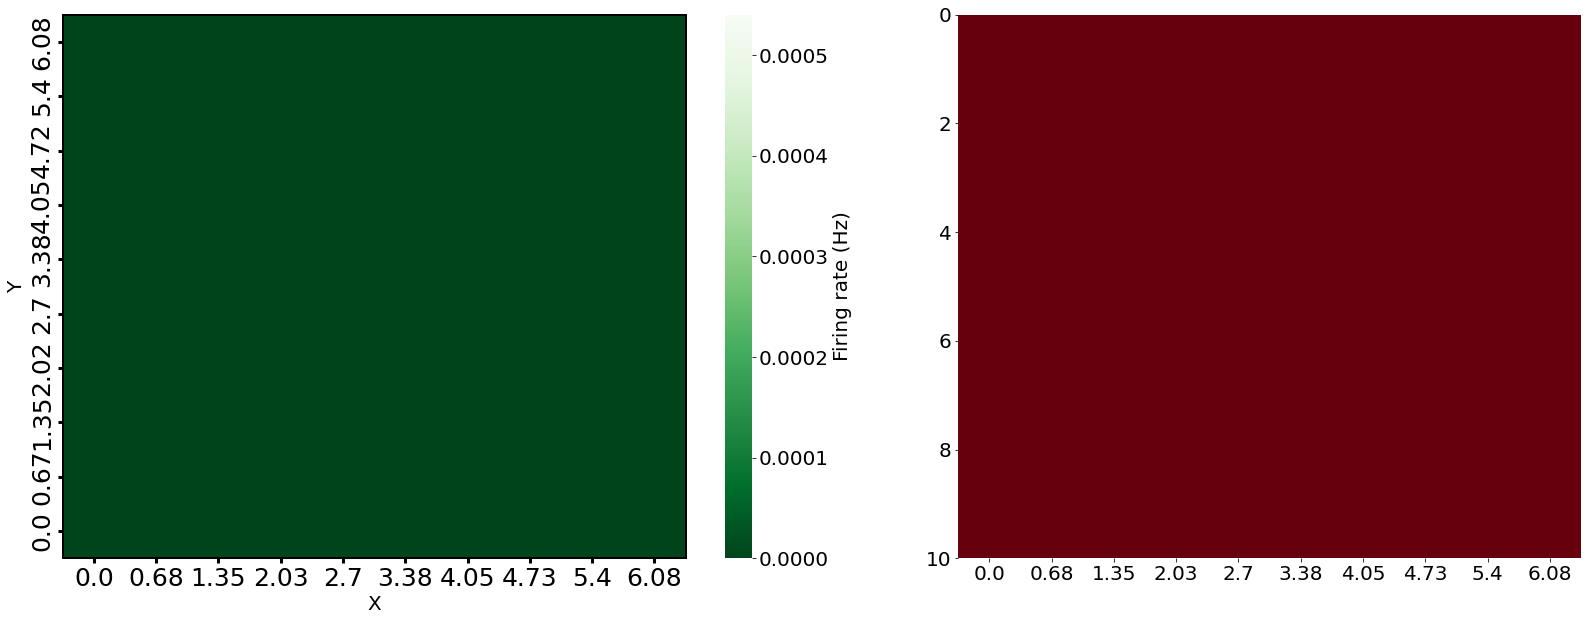

In [34]:
importlib.reload(hmf)
importlib.reload(gdf)
importlib.reload(lm2D)

path_dir = "/user/jemonet/home/Documents/These/Data Macular/(current) BiaisedCorticalConnection_GaussianCorrection/optiParams_noGC_noAma_noSurr_10x10c/white_disk_flash/stim_0,2deg_10ms/tauB_tauG"

reg_caract = re.compile(r"_tauB_G([0-9]{1,3})ms")
reg_n_cells = re.compile(r"([0-9]{1,3})x([0-9]{1,3})")
reg_n_frame = re.compile(r"([0-9]{1,3})f")

delta_t = 0.001 # seconds
frame_rate = 60 # frames per second
size_mm = (6.075,6.075) # degrees

files = [f for f in os.listdir(path_dir) if isfile(join(path_dir,f)) and re.search(r".*\.csv",f)!=None and reg_caract.findall(f) != None]
files.sort(key = lambda x : int(reg_caract.findall(x)[0]))

for file in files:
    caract = int(reg_caract.findall(file)[0])
    n_cells = [int(i) for i in reg_n_cells.findall(file)[0]]
    n_frame = int(reg_n_frame.findall(file)[0])
    name_directory = f"frames_ve_vi_tauB_G{caract}"
    
    if name_directory not in os.listdir(path_dir):
        os.mkdir(f"{path_dir}/{name_directory}")
       
    path_load = f"{path_dir}/{file}"
    print(path_load)
    
    df = gdf.GraphDF(path_load,delta_t,frame_rate,n_cells[0],n_cells[1])
    df = df.crop(df.dt*n_frame)
    print(1)

    df_exc = df.isolate_dataframe_bytype("CorticalExcitatory")
    df_exc = df_exc.isolate_dataframe_byoutputs("v_e")
    df_inh = df.isolate_dataframe_bytype("CorticalInhibitory")
    df_inh = df_inh.isolate_dataframe_byoutputs("v_i")
    print(2)

    list_2Dm, list_t , min_value, max_value = df_exc.export_rows_to_2DmatrixList(size_mm, n_cells)
    mat2D_exc = lm2D.listMatrix2D(list_2Dm, list_t , min_value, max_value)
    list_2Dm, list_t , min_value, max_value = df_inh.export_rows_to_2DmatrixList(size_mm, n_cells)
    mat2D_inh = lm2D.listMatrix2D(list_2Dm, list_t , min_value, max_value)
    print(3)
    
    params_fig = dict(wspace=0.15,hspace=0.4)

    info_fig = {"title":f"Heatmap des activités pour tauB et tauG à {caract} ms", "subtitles":["Excitatory activity","Inhibitory activity"],
                "xlabel":"X coordinate (°)","ylabel":"Y coordinate (°)", "colorbar_label":"Firing rate (Hz)",
                "sharex":True,"sharey":False}

    font_size = {"main_title":35, "subtitle":25, "xlabel":25, "ylabel":25, "g_xticklabel":15, "g_yticklabel":15, "legend":10, "global":20}

    params_plot = {"grid_color":"lightgray","grid_width":4,"ticklength":5,"tickwidth":3, "labelpad":15, "col_map":["Greens_r","Reds_r"]}

    f = hmf.heatMapFigure([mat2D_exc, mat2D_inh],dict_info_fig=info_fig, dict_font_size=font_size,dict_params_plot=params_plot, dict_params_fig=params_fig)
    f.set_plot(f"{path_dir}/{name_directory}")


In [ ]:
importlib.reload(hf)

path_dir = "/user/jemonet/home/Documents/These/Data Macular/(current) BiaisedCorticalConnection_GaussianCorrection/optiParams_noGC_noAma_noSurr_10x10c/white_disk_flash/stim_0,2deg_10ms/tauB_tauG"

for caract in ("20","40","100"):
    path = f"{path_dir}/frames_ve_vi_tauB_G{caract}"
    print(path)
    hf.images_to_video(f"nue_nui_optiParams_noGC_noAma_noSurr_tauB_G{caract}.mp4",path, path_video = path)

### Heatmap de VSDI

/user/jemonet/home/Documents/These/Data Macular/(current) BiaisedCorticalConnection_GaussianCorrection/optiParams_noGC_noAma_noSurr_10x10c/white_disk_flash/stim_0,2deg_10ms/tauB_tauG/10x10_optiParams_tauB_G20ms_61f.csv
1
2
3


KeyboardInterrupt: 

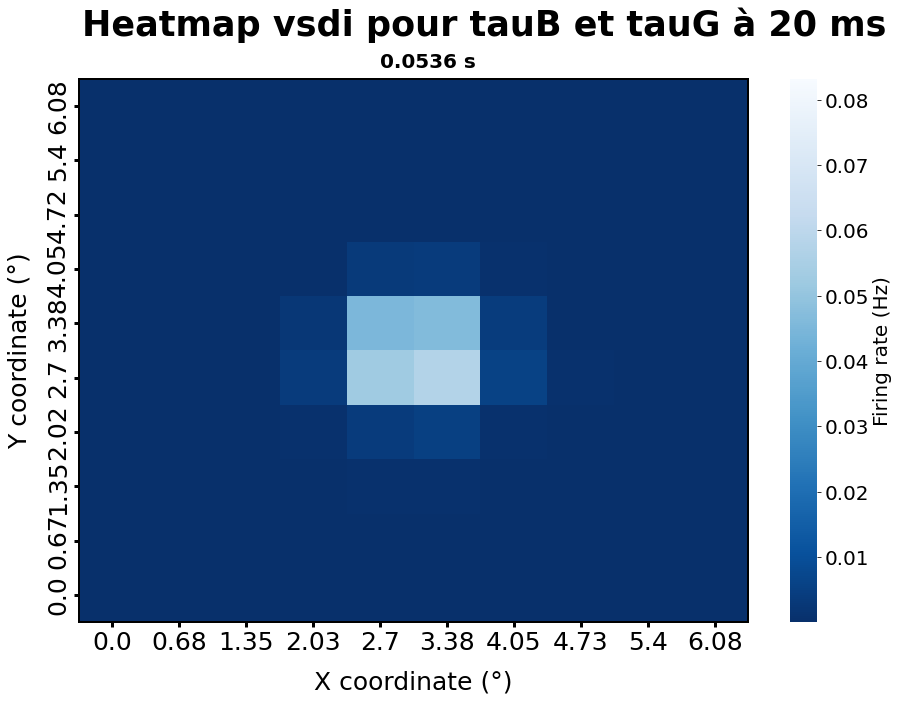

In [49]:
importlib.reload(hmf)
importlib.reload(gdf)
importlib.reload(lm2D)

path_dir = "/user/jemonet/home/Documents/These/Data Macular/(current) BiaisedCorticalConnection_GaussianCorrection/optiParams_noGC_noAma_noSurr_10x10c/white_disk_flash/stim_0,2deg_10ms/tauB_tauG"

reg_caract = re.compile(r"_tauB_G([0-9]{1,3})ms")
reg_n_cells = re.compile(r"([0-9]{1,3})x([0-9]{1,3})")
reg_n_frame = re.compile(r"([0-9]{1,3})f")

delta_t = 0.001 # seconds
frame_rate = 60 # frames per second
size_mm = (6.075,6.075) # degrees

files = [f for f in os.listdir(path_dir) if isfile(join(path_dir,f)) and re.search(r".*\.csv",f)!=None and reg_caract.findall(f) != None]
files.sort(key = lambda x : int(reg_caract.findall(x)[0]))

for file in files:
    caract = int(reg_caract.findall(file)[0])
    n_cells = [int(i) for i in reg_n_cells.findall(file)[0]]
    n_frame = int(reg_n_frame.findall(file)[0])
    name_directory = f"frames_vsdi_tauB_G{caract}"
    
    if name_directory not in os.listdir(path_dir):
        os.mkdir(f"{path_dir}/{name_directory}")
       
    path_load = f"{path_dir}/{file}"
    print(path_load)
    
    df = gdf.GraphDF(path_load,delta_t,frame_rate,n_cells[0],n_cells[1])
    df = df.crop(df.dt*n_frame)
    print(1)

    df = df.isolate_dataframe_byoutputs("muVn")
    exc = df.isolate_dataframe_bytype("CorticalExcitatory")
    inh = df.isolate_dataframe_bytype("CorticalInhibitory")
    
    exc.data = (abs((exc.data - exc.data.iloc[0].mean())) / abs(exc.data.iloc[0].mean()))
    inh.data = (abs((inh.data - inh.data.iloc[0].mean())) / abs(inh.data.iloc[0].mean()))
    col_exc_rename = {exc.data.columns[i]:f"CorticalColumn ({i}) vsdi" for i in range(exc.data.columns.shape[0])}
    col_inh_rename = {inh.data.columns[i]:f"CorticalColumn ({i}) vsdi" for i in range(exc.data.columns.shape[0])}
    exc.data = exc.data.rename(columns=col_exc_rename)
    inh.data = inh.data.rename(columns=col_inh_rename)
    vsdi = exc.copy()
    vsdi.data=exc.data*0.8+inh.data*0.2    
    print(2)

    list_2Dm, list_t , min_value, max_value = vsdi.export_rows_to_2DmatrixList(size_mm, n_cells)
    mat2D_vsdi = lm2D.listMatrix2D(list_2Dm, list_t , min_value, max_value)
    print(3)
    
    params_fig = dict(wspace=0.15,hspace=0.4)

    info_fig = {"title":f"Heatmap vsdi pour tauB et tauG à {caract} ms", "subtitles":[""],
                "xlabel":"X coordinate (°)","ylabel":"Y coordinate (°)", "colorbar_label":"Firing rate (Hz)",
                "sharex":True,"sharey":False}

    font_size = {"main_title":35, "subtitle":25, "xlabel":25, "ylabel":25, "g_xticklabel":15, "g_yticklabel":15, "legend":10, "global":20}

    params_plot = {"grid_color":"lightgray","grid_width":4,"ticklength":5,"tickwidth":3, "labelpad":15, "col_map":["Blues_r"]}

    f = hmf.heatMapFigure([mat2D_vsdi],sizeX=15, sizeY=10, dict_info_fig=info_fig, dict_font_size=font_size,dict_params_plot=params_plot, dict_params_fig=params_fig)
    f.set_plot(f"{path_dir}/{name_directory}")

In [50]:
importlib.reload(hf)

path_dir = "/user/jemonet/home/Documents/These/Data Macular/(current) BiaisedCorticalConnection_GaussianCorrection/optiParams_noGC_noAma_noSurr_10x10c/white_disk_flash/stim_0,2deg_10ms/tauB_tauG"

for caract in ("20","40","100"):
    path = f"{path_dir}/frames_vsdi_tauB_G{caract}"
    print(path)
    hf.images_to_video(f"vsdi_optiParams_noGC_noAma_noSurr_tauB_G{caract}.mp4",path, path_video = path)

/user/jemonet/home/Documents/These/Data Macular/(current) BiaisedCorticalConnection_GaussianCorrection/optiParams_noGC_noAma_noSurr_10x10c/white_disk_flash/stim_0,2deg_10ms/tauB_tauG/frames_vsdi_tauB_G20
